In [1]:
import math
import numpy as np
import torch
import torch.utils.checkpoint
import torchvision
import matplotlib.pyplot as plt

from torchvision import transforms
from tqdm.auto import tqdm

from rectified_flow.rectified_flow import RectifiedFlow
from rectified_flow.utils import match_dim_with_data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

In [2]:
batch_size = 512

transform_list = [
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
]
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.Compose(transform_list)
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,          
    pin_memory=True,
    persistent_workers=False,
)

batch = next(iter(train_dataloader))
print(batch[0].shape)  # torch.Size([256, 1, 28, 28])

torch.Size([512, 1, 28, 28])


In [3]:
model_type = "unet"
from rectified_flow.models.enhanced_mlp import VarMLP
from rectified_flow.models.utils import EMAModel
from rectified_flow.models.unet import SongUNet, SongUNetConfig

flow_model = SongUNet.from_pretrained("/scratch/10992/liaorunlong93/random_flow_toys/checkpoints/flow_mnist_unet_unconditional", use_ema=True).to(device)

Model loaded from /scratch/10992/liaorunlong93/random_flow_toys/checkpoints/flow_mnist_unet_unconditional/unet_ema.pt


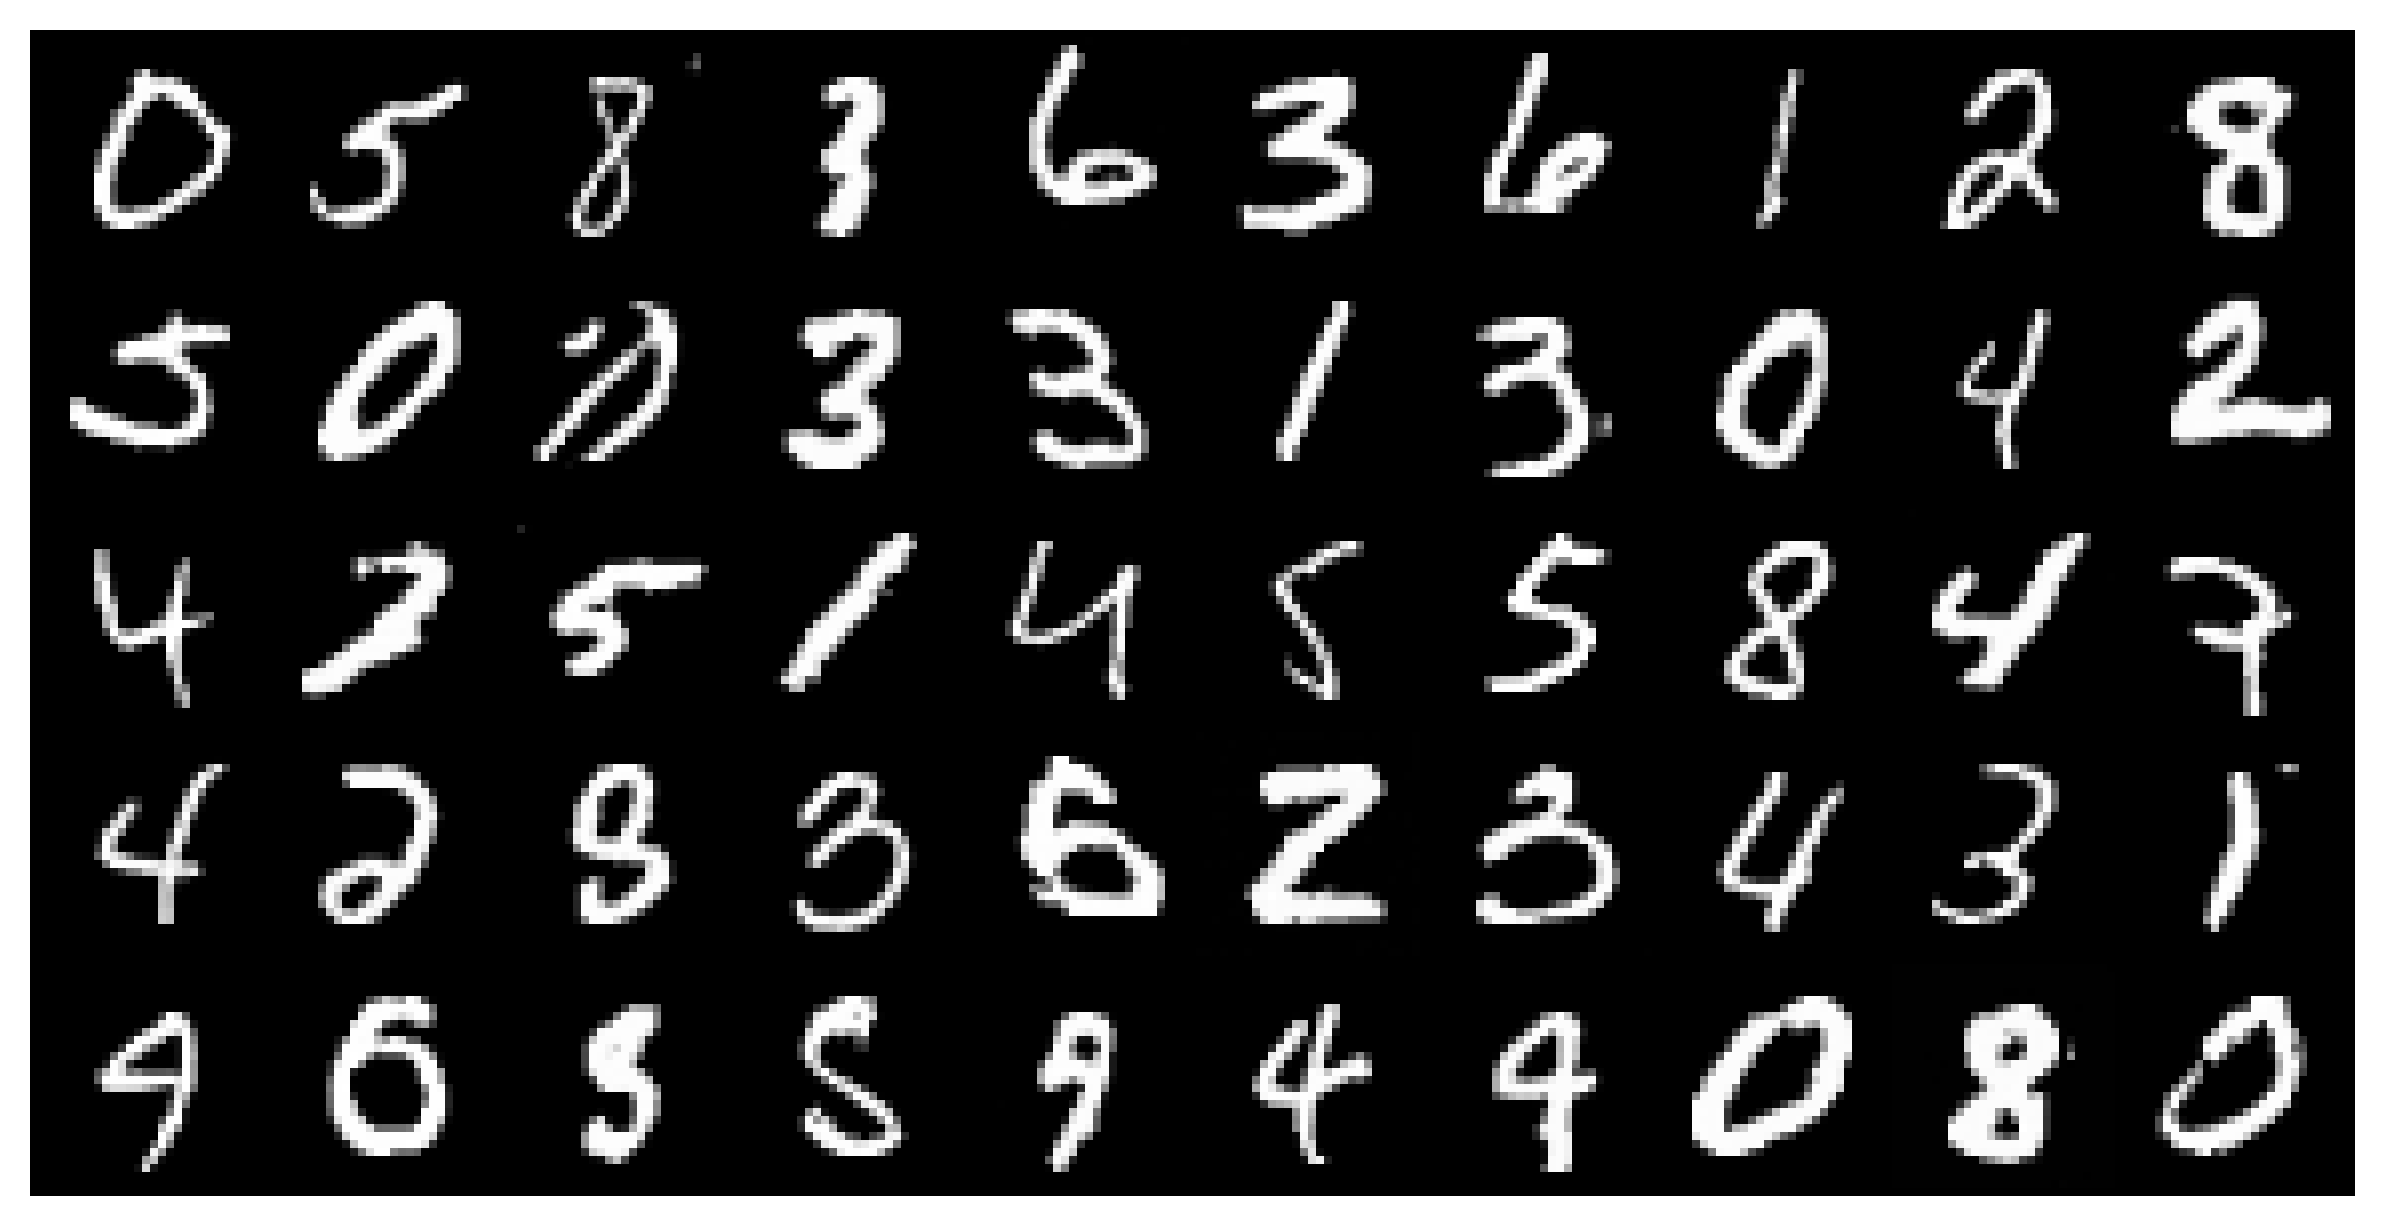

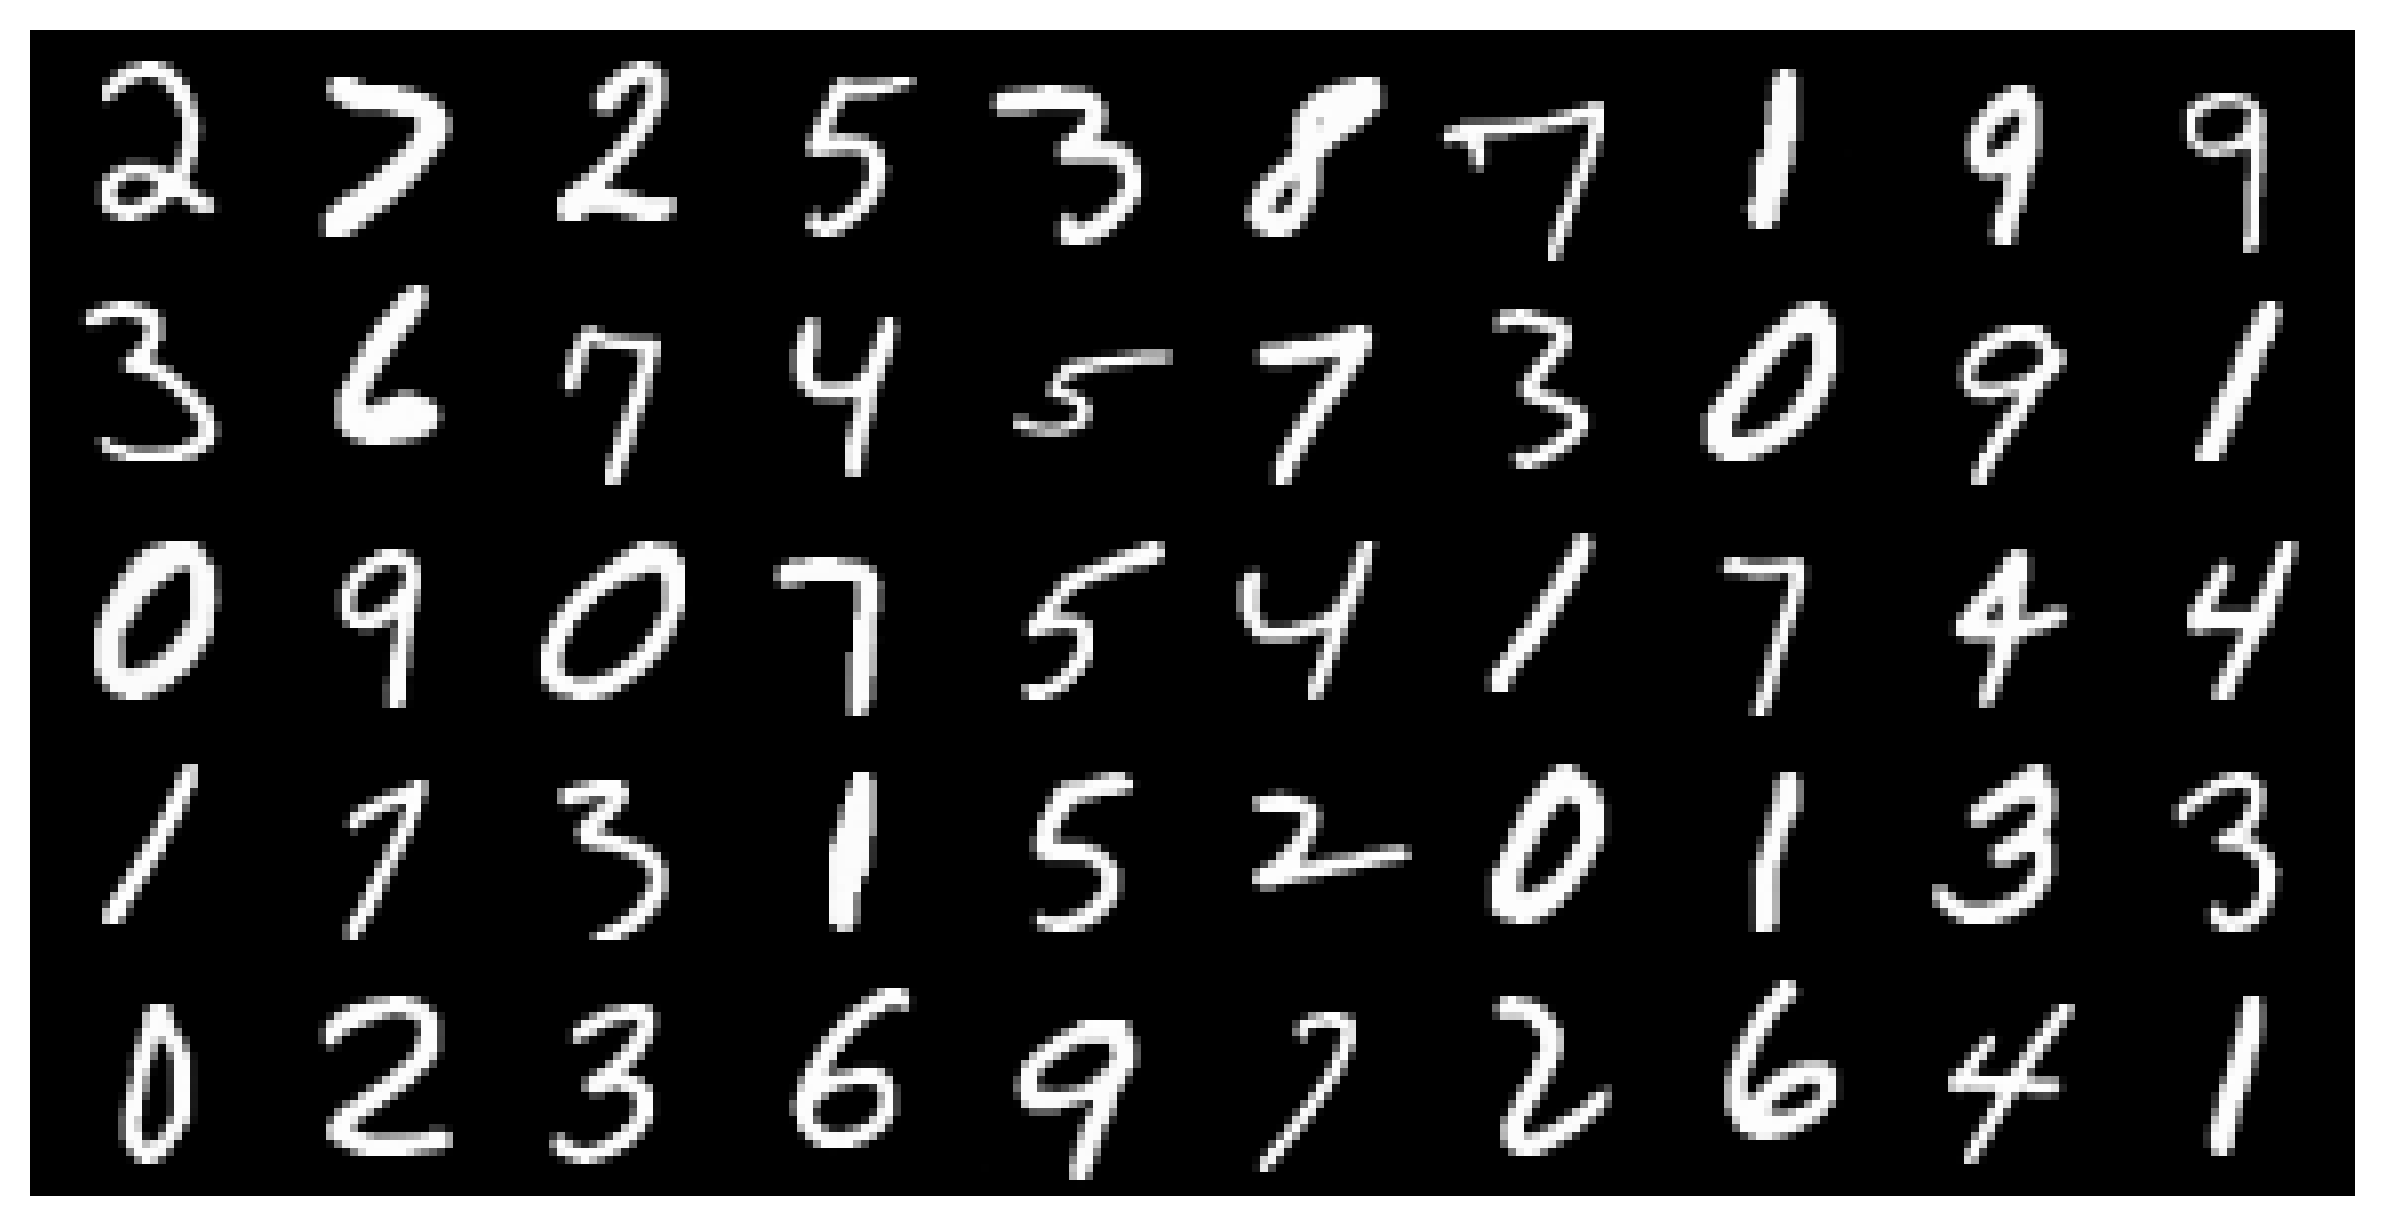

In [4]:
from rectified_flow.samplers import EulerSampler, SDESampler
from rectified_flow.utils import plot_cifar_results

rf = RectifiedFlow(
    data_shape=(1, 28, 28),
    velocity_field=flow_model,
    device=device,
)

x_0_src = torch.randn(50, 1, 28, 28, device=device)

sampler = EulerSampler(rectified_flow=rf, num_steps=200)
rf_samples = sampler.sample_loop(x_0=x_0_src).trajectories[-1]

sde_sampler = SDESampler(rectified_flow=rf, num_steps=100, noise_decay_rate=0.0, noise_scale=50.0)
rf_sde_samples = sde_sampler.sample_loop(x_0=x_0_src).trajectories[-1]

plot_cifar_results(rf_samples)
plot_cifar_results(rf_sde_samples)

## Implement divergence estimation and verify correctness

### Exact Jacobian calculation with autograd

In [5]:
from tqdm import tqdm
from torch.autograd.functional import jacobian

def divergence_exact_manual(v_func, x_t, t):
    device, dtype = x_t.device, x_t.dtype
    B = x_t.shape[0]
    div = torch.empty(B, device=device, dtype=dtype)

    for b in tqdm(range(B), desc="Computing exact divergence"):
        xb = x_t[b:b+1].detach().requires_grad_(True)
        tb = t[b:b+1]

        def f(inp):
            return v_func(inp, tb)

        J = jacobian(f, xb, vectorize=False, create_graph=False)
        D = xb.numel()
        div[b] = J.reshape(D, D).diagonal().sum().to(dtype)
        del J
        
    return div

### Divergence Estimation via the Hutchinson Trick

For a vector field $v(x,t)$ with Jacobian $J(x) = \dfrac{\partial v}{\partial x}$, the divergence is
$$
\operatorname{div} v(x,t) = \operatorname{tr}\, J(x).
$$
Computing $\operatorname{tr} J$ via an explicit Jacobian is expensive. The Hutchinson identity gives an unbiased estimator:
$$
\operatorname{tr} J = \mathbb{E}_{\varepsilon}\!\left[\varepsilon^\top J \varepsilon\right],
$$
where $\varepsilon$ can be Rademacher ($\pm1$ w.p. 1/2) or standard Gaussian. A Monte Carlo estimate is
$$
\widehat{\operatorname{div}}(x,t) = \frac{1}{M}\sum_{i=1}^{M} \varepsilon_i^\top (J\,\varepsilon_i),
$$
which only requires Jacobian–vector products (JVP) or vector–Jacobian products (VJP), avoiding materializing the full Jacobian.

**Implementation notes**
- `eps_dist="rademacher"` often yields slightly lower variance; `"normal"` works too.
- Use forward-mode `jvp` to get $J\varepsilon$, or a single backward (VJP) to get $J^\top \varepsilon$ and then dot with $\varepsilon$.
- Compute per-sample inner products in the batch and average across $M$ probes; `M=1–4` is typically sufficient.
- When using fp16/bf16, accumulate in fp32 for numerical stability.


In [6]:
from torch.func import jvp as jvp_func

def divergence_hutchinson(
    v_func,
    x_t: torch.Tensor,
    t: torch.Tensor,
    n_samples: int = 20,
    eps_dist: str = "rademacher",
    method: str = "vjp",
) -> torch.Tensor:
    device, dtype = x_t.device, x_t.dtype
    B = x_t.shape[0]
    D = x_t.numel() // B

    x_flat = x_t.detach().view(B, D)

    acc_dtype = torch.float32 if dtype in (torch.float16, torch.bfloat16) else dtype
    acc = torch.zeros(B, device=device, dtype=acc_dtype)

    def _sample_eps_flat():
        if eps_dist == "rademacher":
            r = torch.randint(0, 2, (B, D), device=device)
            eps = (r * 2 - 1).to(acc_dtype)
        elif eps_dist == "normal":
            eps = torch.randn((B, D), device=device, dtype=acc_dtype)
        else:
            raise ValueError("eps_dist must be 'rademacher' or 'normal'")
        return eps.to(dtype)

    if method == "jvp":
        def f_flat(inp_flat):
            x4 = inp_flat.view(B, *x_t.shape[1:])
            y4 = v_func(x4, t)
            return y4.view(B, D)

        for _ in range(n_samples):
            eps_flat = _sample_eps_flat()
            _, jvp_out = jvp_func(f_flat, (x_flat,), (eps_flat,), strict=False)  # <-- fix
            acc += (eps_flat * jvp_out).sum(dim=1).to(acc_dtype)

        return (acc / n_samples).to(dtype)

    elif method == "vjp":
        for _ in range(n_samples):
            eps_flat = _sample_eps_flat()
            eps = eps_flat.view_as(x_t)
            x_req = x_t.detach().requires_grad_(True)
            v = v_func(x_req, t)
            s_per_sample = (v * eps).view(B, -1).sum(dim=1)
            gx = torch.autograd.grad(
                s_per_sample.sum(), x_req, create_graph=False, retain_graph=False
            )[0]
            acc += (gx.detach() * eps).view(B, -1).sum(dim=1).to(acc_dtype)
            del x_req, v, gx, eps, eps_flat, s_per_sample

        return (acc / n_samples).to(dtype)

    else:
        raise ValueError("method must be 'jvp' or 'vjp'")

In [7]:
x_1 = batch[0].to(device)[233:234]
x_1 = x_1.repeat_interleave(6, dim=0)
t = torch.linspace(0.95, 1.0, steps=x_1.shape[0], device=device)
x_t = t[:, None, None, None] * x_1 + (1 - t)[:, None, None, None] * torch.randn_like(x_1)

div_exact = divergence_exact_manual(flow_model, x_t, t)
div_approx = divergence_hutchinson(flow_model, x_t, t, n_samples=20, method="vjp")

print("Divergence shape:", div_exact.shape)
print("div exact:", div_exact)
print("div approx:", div_approx)
print("Max absolute error:", (div_exact - div_approx).abs().max().item())

Computing exact divergence: 100%|██████████| 6/6 [00:32<00:00,  5.35s/it]


Divergence shape: torch.Size([6])
div exact: tensor([-13289.4297, -17670.8320, -22357.4297, -33850.9023, -63879.6367,
        -21235.7578], device='cuda:0')
div approx: tensor([-13306.4766, -17595.0840, -22378.0234, -33692.9102, -63592.5625,
        -21000.1035], device='cuda:0')
Max absolute error: 287.07421875


## log prob estimation with Simultaneous change of variable


$$
\log \rho_t(x^{\mathrm{eval}}) 
= 
\log \rho_0(z_0^{\mathrm{eval}}) 
- 
\int_0^1 \nabla \cdot v_t(z_t^{\mathrm{eval}}) \, \mathrm dt,
$$

where $ \{ z_t^{\mathrm{eval}} \} $ is the solution of 

$$
\dot{z}_t^{\mathrm{eval}} = v_t(z_t^{\mathrm{eval}}), 
\quad \text{with} \quad 
z_1^{\mathrm{eval}} = x^{\mathrm{eval}}.
$$



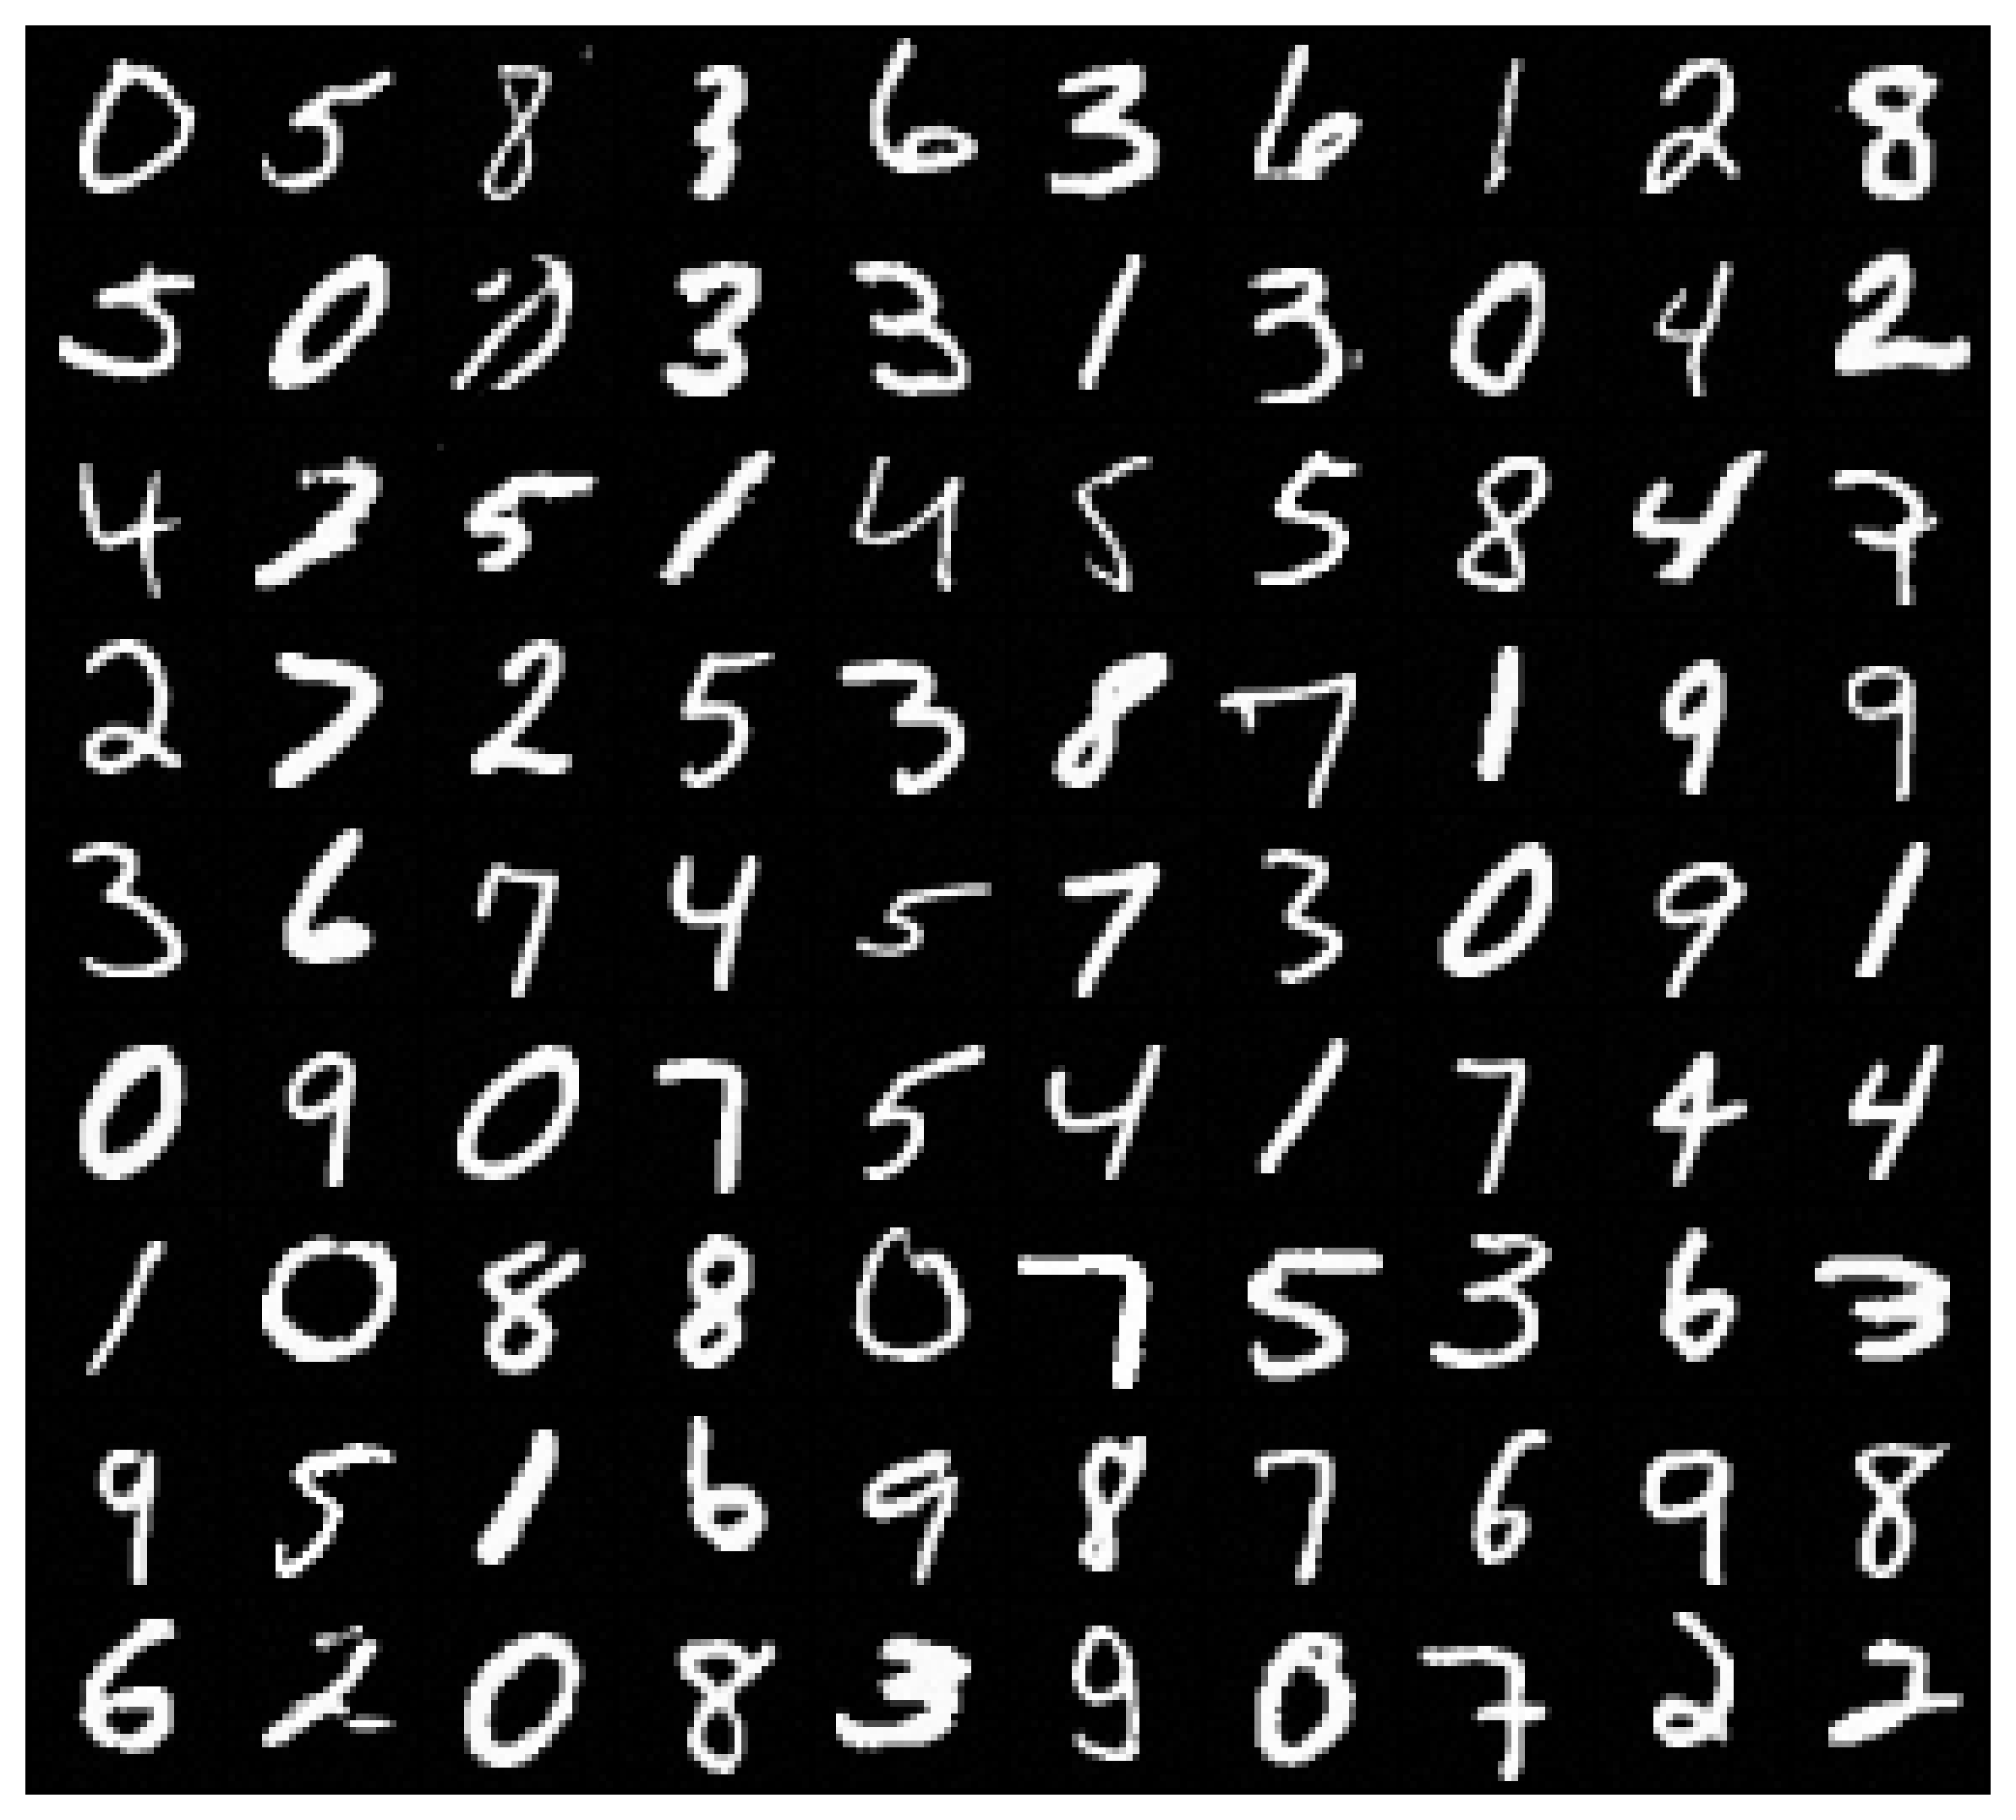

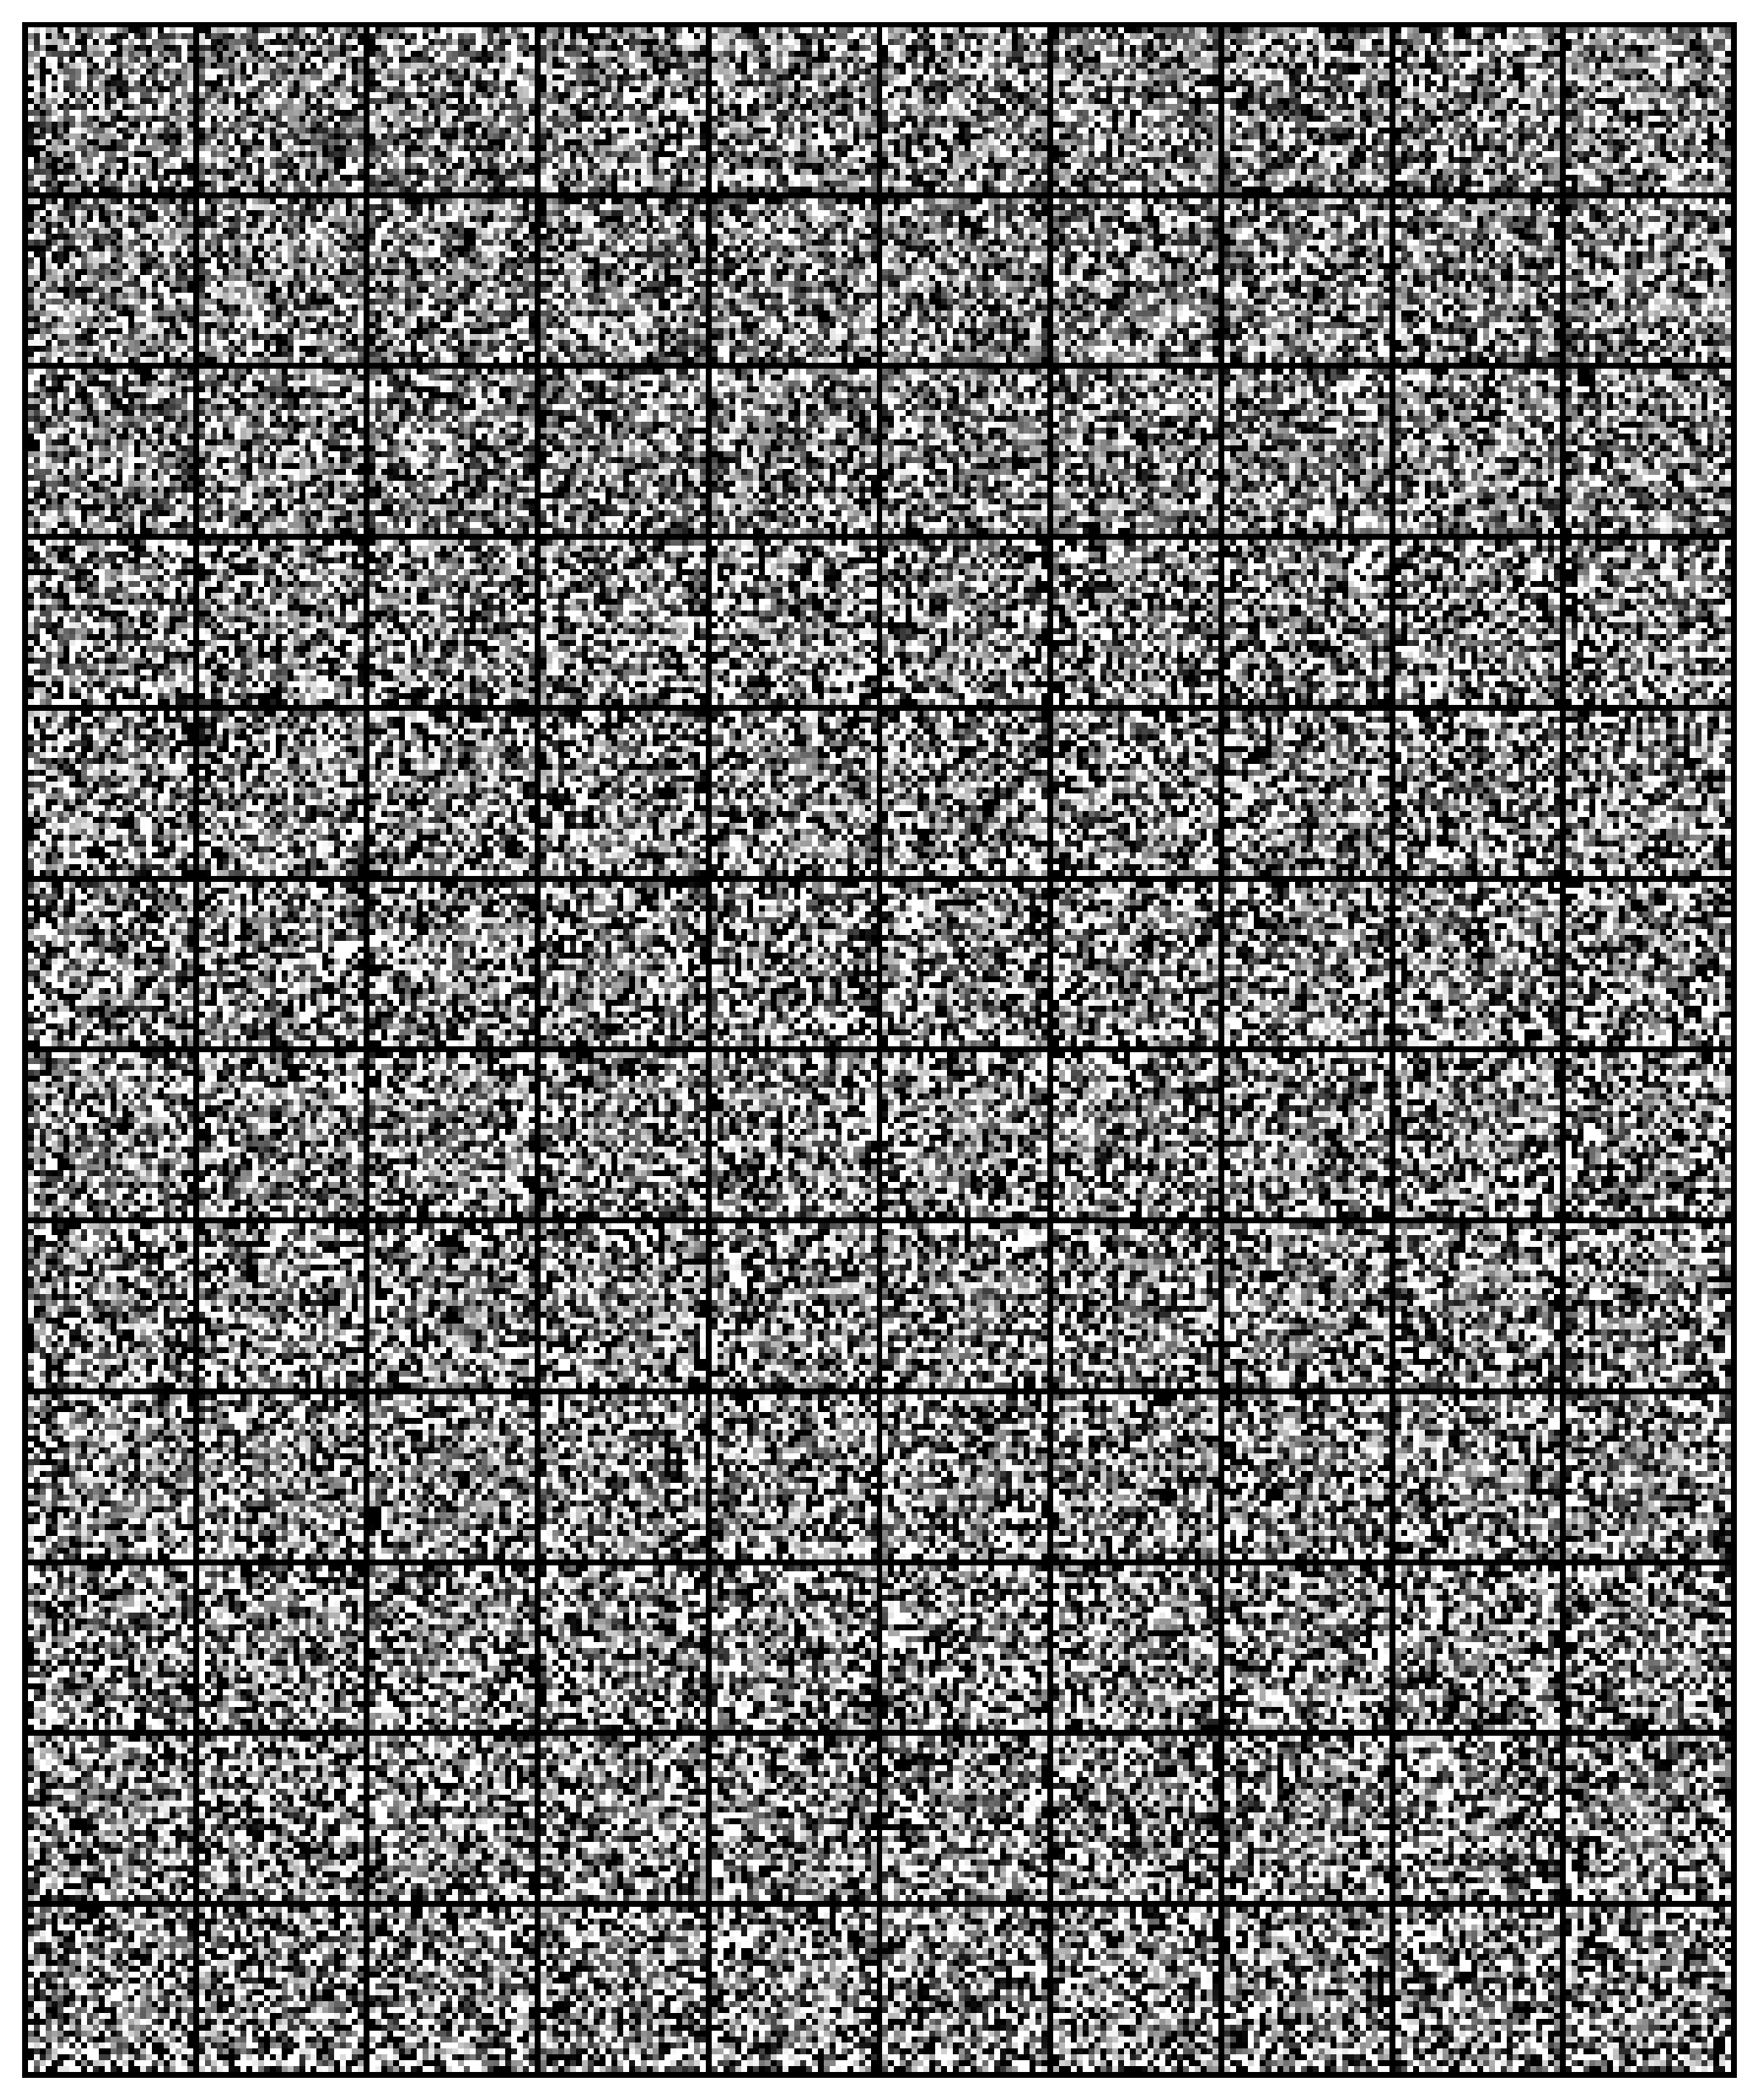

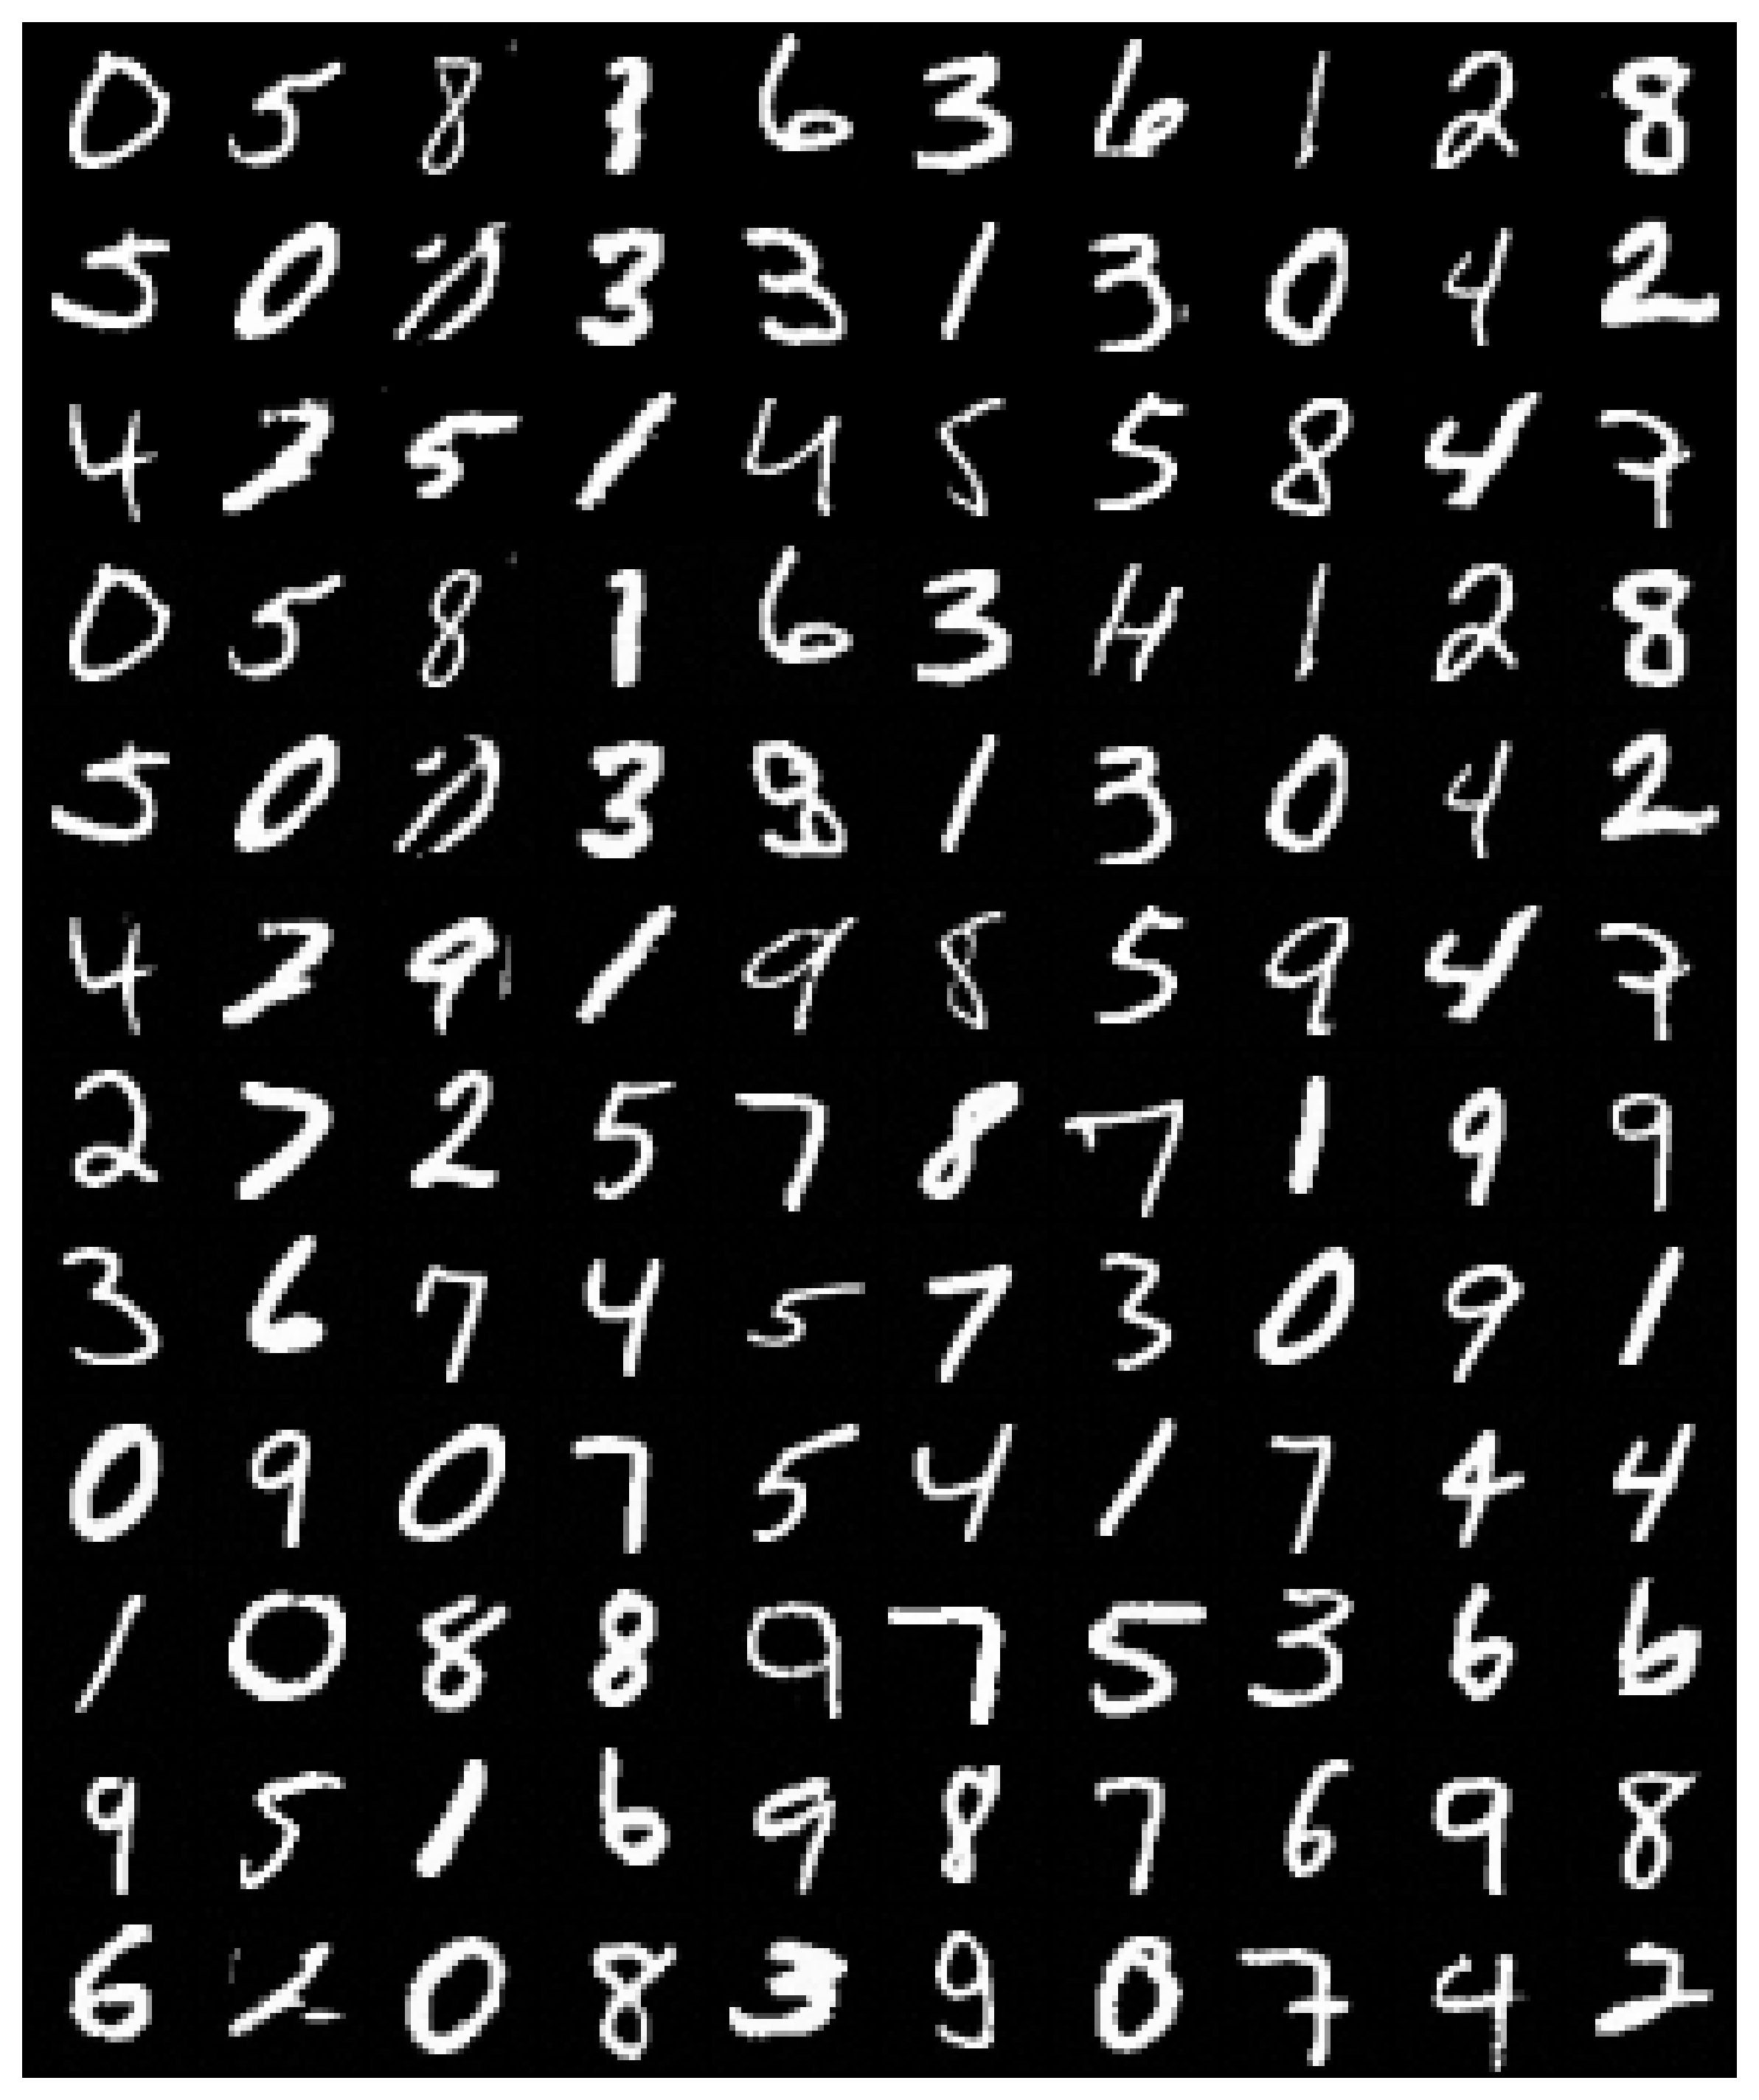

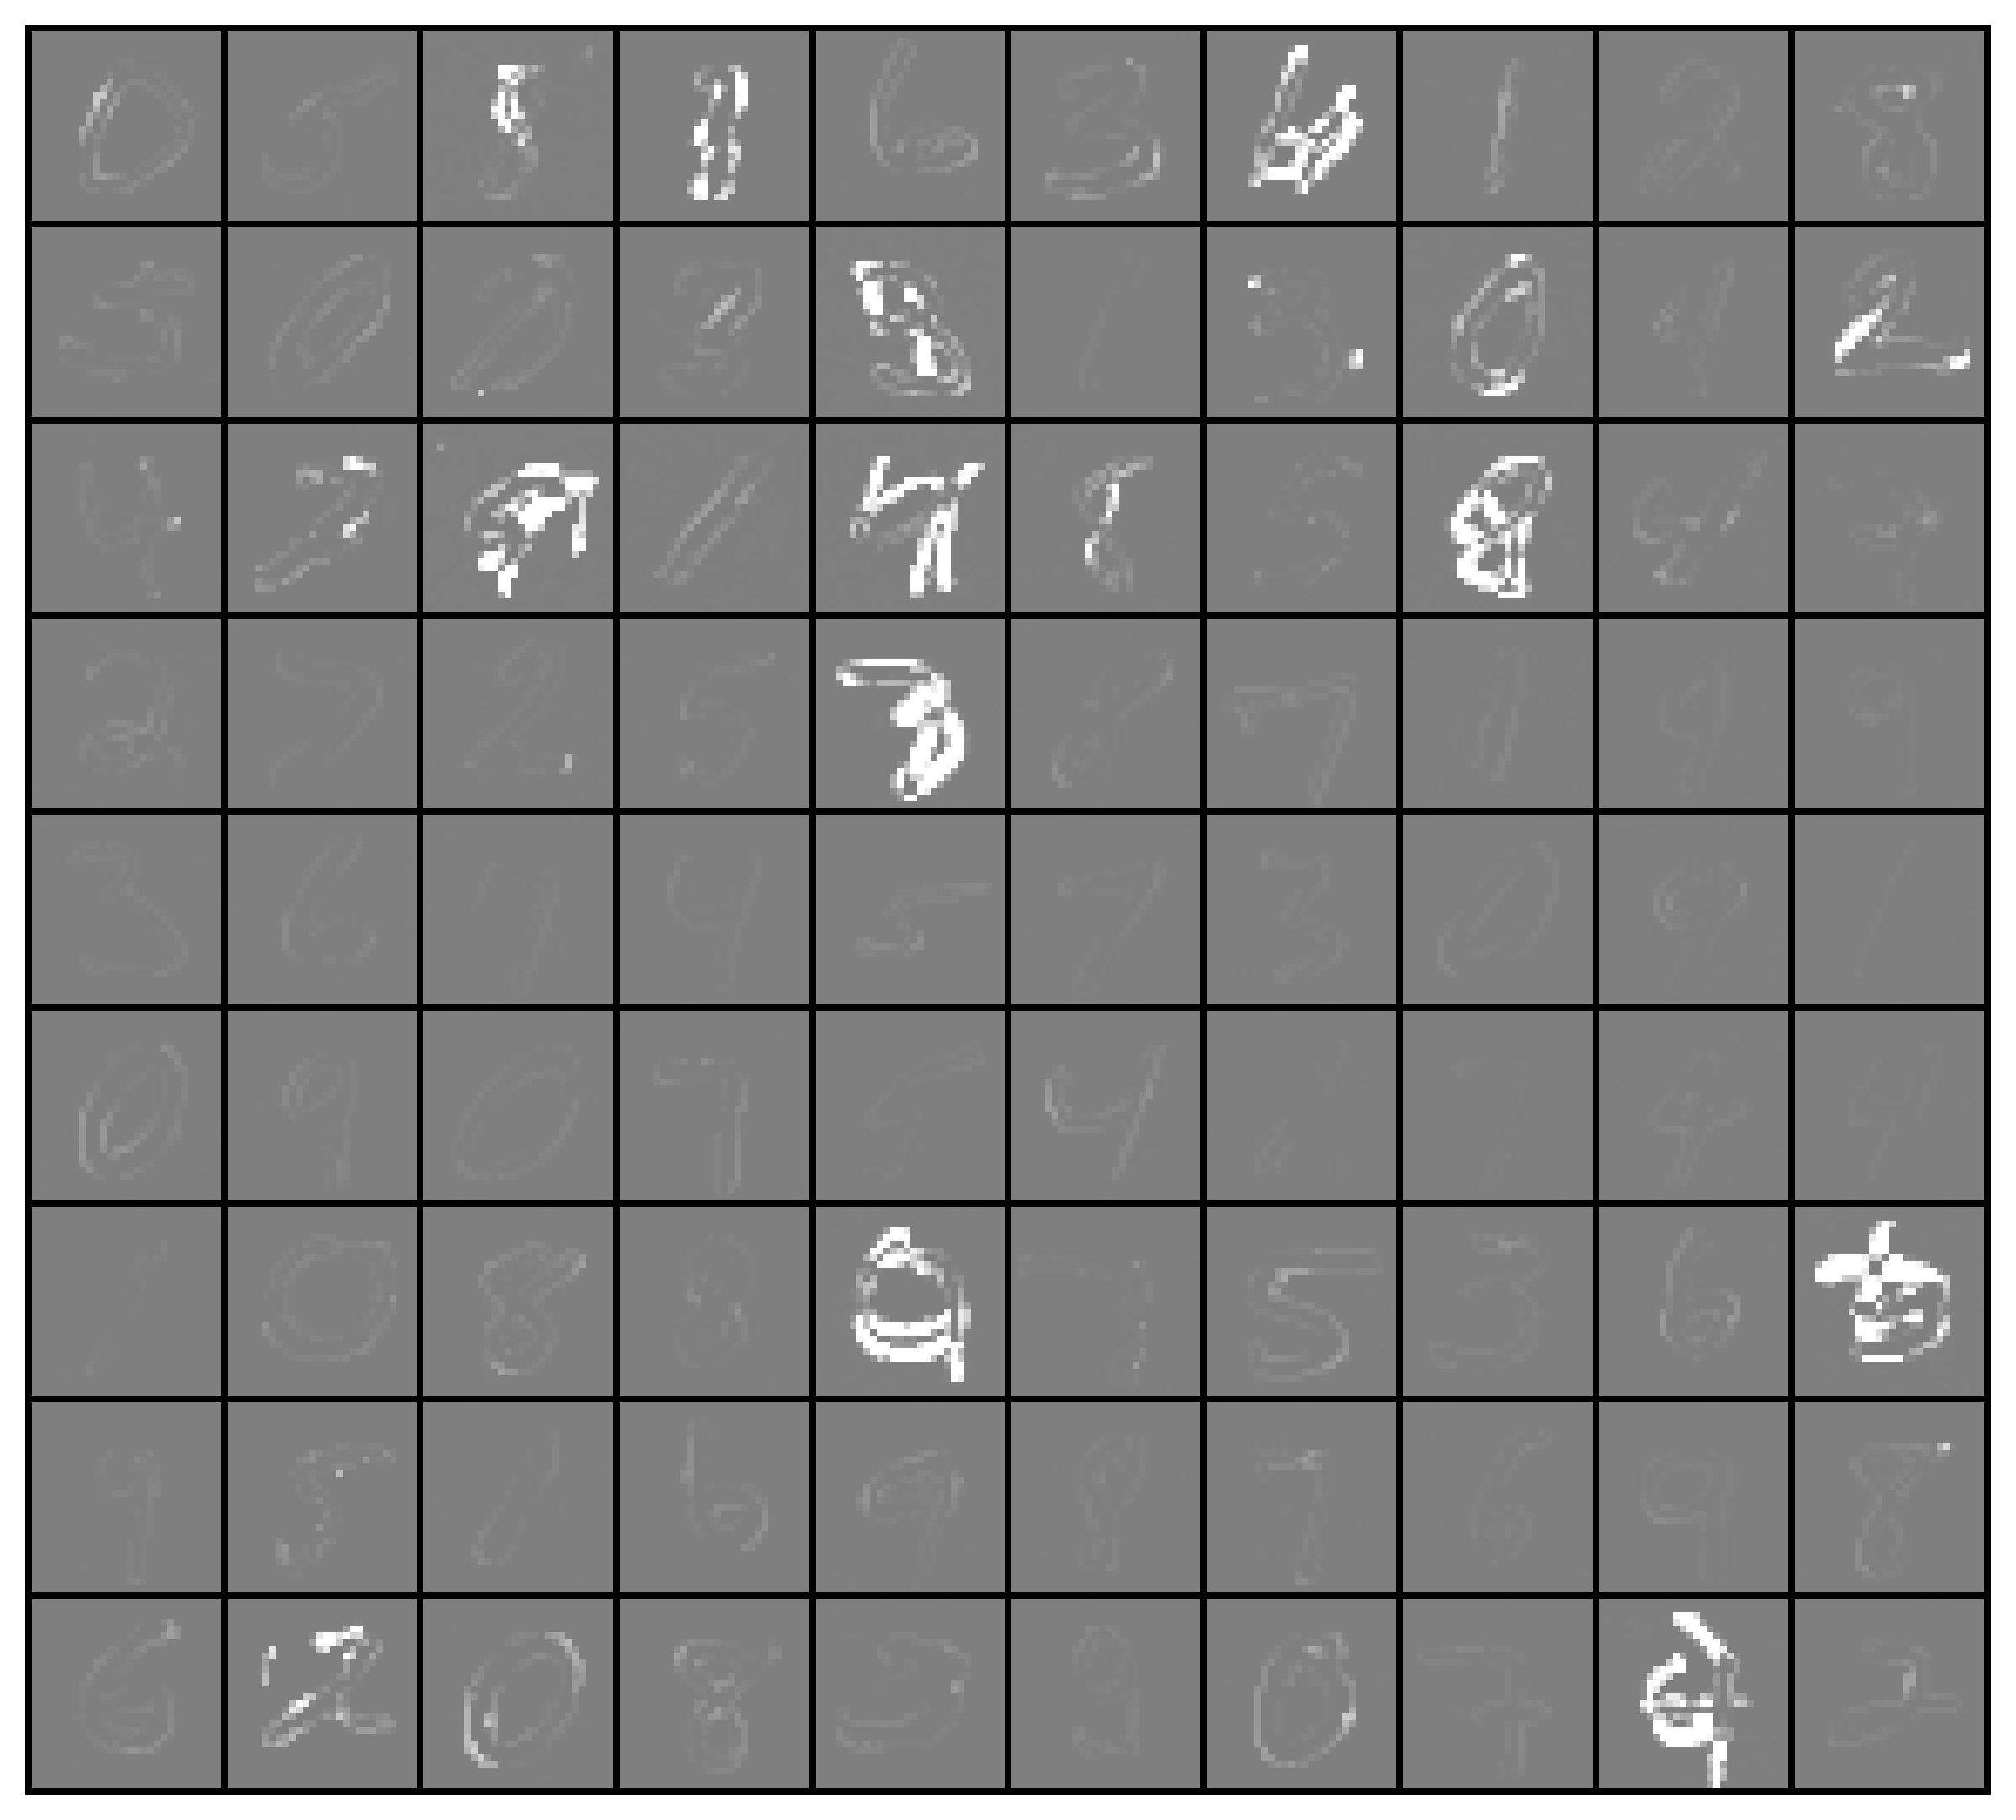

In [8]:
n_samples = 30

x_eval = batch[0].to(device)[:n_samples]
x_eval = torch.cat([
        rf_samples[:n_samples],     # ODE inv
        rf_sde_samples[:n_samples], # SDE inv
        x_eval,              # Test set inv
    ], dim=0)
alpha = 0.01
x_eval = (1. - alpha) * x_eval + alpha * torch.randn_like(x_eval)
# x_eval = x_1
N = 1000
plot_cifar_results(x_eval)

# Generate an ODE trajectory for evaluation
time_grid = torch.linspace(0., 1. - alpha, N, device=device)
inv_rf = RectifiedFlow(
    data_shape=(1, 28, 28),
    velocity_field=lambda x, t: -flow_model(x, 1. - t),
    device=device,
)
sampler_inv = EulerSampler(rectified_flow=inv_rf, time_grid=time_grid)
x_0_inv = sampler_inv.sample_loop(x_0=x_eval).trajectories[-1]
x_0_inv = torch.cat((x_0_src[:n_samples], x_0_inv), dim=0) # [ODE vanilla, ODE inv, SDE inv, Test set inv]
plot_cifar_results(x_0_inv)

# Now generate samples from x_0_inv back to x_eval, to see how well we reconstruct
rf = RectifiedFlow(
    data_shape=(1, 28, 28),
    velocity_field=flow_model,
    device=device,
)
sampler = EulerSampler(rectified_flow=rf, num_samples=50, num_steps=N)
x_1 = sampler.sample_loop(x_0=x_0_inv).trajectories[-1]
plot_cifar_results(x_1)
plot_cifar_results(torch.abs(x_1[n_samples:] - x_eval))

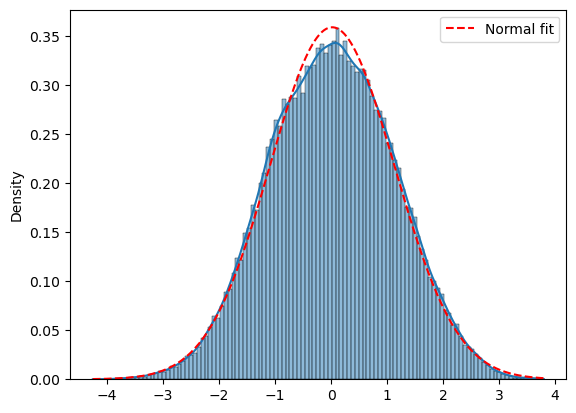

In [9]:
import seaborn as sns
import scipy.stats as stats

x = x_0_inv.view(-1).cpu().numpy()
sns.histplot(x, kde=True, stat="density")
mu, sigma = x.mean(), x.std()
xs = np.linspace(x.min(), x.max(), 200)
plt.plot(xs, stats.norm.pdf(xs, mu, sigma), 'r--', label='Normal fit')
plt.legend()
plt.show()

In [10]:
def standard_normal_logprob(z):
    B = z.shape[0]
    zf = z.view(B, -1)
    D = zf.shape[1]
    return -0.5 * (zf.pow(2).sum(dim=1) + D * math.log(2 * math.pi))

def estimate_logprob_from_inverse(
    x_0_inv: torch.Tensor,
    rf,                      
    flow_model,
    N: int = 300,
    alpha: float = 0.0,       
    sample_stride: int = 5,
):
    device = x_0_inv.device
    B = x_0_inv.shape[0]

    t1 = max(0.0, 1.0 - alpha)
    time_grid = torch.linspace(0., t1, N, device=device)

    sampler_fwd = EulerSampler(rectified_flow=rf, time_grid=time_grid)
    traj = sampler_fwd.sample_loop(x_0=x_0_inv).trajectories
    states = torch.stack(traj, dim=0) if isinstance(traj, list) else traj     # (T, B, C, H, W)
    T = states.shape[0]

    idx = torch.arange(0, T, sample_stride, device=device)
    if idx[-1].item() != T - 1:
        idx = torch.cat([idx, torch.tensor([T - 1], device=device)])
    t_used = time_grid.index_select(0, idx)               # (Ts,)
    x_used = states.index_select(0, idx)                  # (Ts, B, C, H, W)

    div_values = []
    for k in tqdm(range(t_used.shape[0]), desc="Computing divergences"):
        tk = t_used[k]
        xk = x_used[k]                                     # (B, C, H, W)
        tb = torch.full((B,), tk.item(), device=device)    # (B,)
        div_k = divergence_hutchinson(flow_model, xk, tb, n_samples=30)  # (B,)
        div_values.append(div_k)
        print(f"Time {tk.item():.5f} divergence mean: {div_k.mean().item():.4f}")
    divs = torch.stack(div_values, dim=0)                  # (Ts, B)

    int_div = torch.trapz(divs, t_used, dim=0)            # (B,)
    log_rho0 = standard_normal_logprob(x_0_inv)           # (B,)
    log_rho_eval = log_rho0 - int_div                     # (B,)

    details = {
        "time_grid_full": time_grid,   # (T,)
        "time_grid_used": t_used,      # (Ts,)
        "states_used": x_used,         # (Ts, B, C, H, W)
        "divergences": divs,           # (Ts, B)
        "int_divergence": int_div,     # (B,)
        "log_rho0": log_rho0,          # (B,)
    }
    return log_rho_eval, details

log_rho_eval, details = estimate_logprob_from_inverse(
    x_0_inv=x_0_inv,
    rf=rf,
    flow_model=flow_model,
    N=1000,
    alpha=0.0,
    sample_stride=20,
)

Computing divergences:   2%|▏         | 1/51 [00:00<00:33,  1.48it/s]

Time 0.00000 divergence mean: -775.4400


Computing divergences:   4%|▍         | 2/51 [00:01<00:32,  1.52it/s]

Time 0.02002 divergence mean: -784.0837


Computing divergences:   6%|▌         | 3/51 [00:01<00:31,  1.54it/s]

Time 0.04004 divergence mean: -797.4789


Computing divergences:   8%|▊         | 4/51 [00:02<00:30,  1.55it/s]

Time 0.06006 divergence mean: -808.7547


Computing divergences:  10%|▉         | 5/51 [00:03<00:29,  1.56it/s]

Time 0.08008 divergence mean: -823.9240


Computing divergences:  12%|█▏        | 6/51 [00:03<00:28,  1.56it/s]

Time 0.10010 divergence mean: -835.1621


Computing divergences:  14%|█▎        | 7/51 [00:04<00:28,  1.56it/s]

Time 0.12012 divergence mean: -848.1331


Computing divergences:  16%|█▌        | 8/51 [00:05<00:27,  1.56it/s]

Time 0.14014 divergence mean: -862.2496


Computing divergences:  18%|█▊        | 9/51 [00:05<00:26,  1.56it/s]

Time 0.16016 divergence mean: -881.7064


Computing divergences:  20%|█▉        | 10/51 [00:06<00:26,  1.57it/s]

Time 0.18018 divergence mean: -897.8486


Computing divergences:  22%|██▏       | 11/51 [00:07<00:25,  1.56it/s]

Time 0.20020 divergence mean: -918.8622


Computing divergences:  24%|██▎       | 12/51 [00:07<00:24,  1.56it/s]

Time 0.22022 divergence mean: -940.9700


Computing divergences:  25%|██▌       | 13/51 [00:08<00:24,  1.56it/s]

Time 0.24024 divergence mean: -961.6505


Computing divergences:  27%|██▋       | 14/51 [00:08<00:23,  1.56it/s]

Time 0.26026 divergence mean: -993.4217


Computing divergences:  29%|██▉       | 15/51 [00:09<00:23,  1.56it/s]

Time 0.28028 divergence mean: -1016.6179


Computing divergences:  31%|███▏      | 16/51 [00:10<00:22,  1.56it/s]

Time 0.30030 divergence mean: -1045.4604


Computing divergences:  33%|███▎      | 17/51 [00:10<00:21,  1.56it/s]

Time 0.32032 divergence mean: -1081.0396


Computing divergences:  35%|███▌      | 18/51 [00:11<00:21,  1.56it/s]

Time 0.34034 divergence mean: -1116.5721


Computing divergences:  37%|███▋      | 19/51 [00:12<00:20,  1.56it/s]

Time 0.36036 divergence mean: -1148.4260


Computing divergences:  39%|███▉      | 20/51 [00:12<00:19,  1.56it/s]

Time 0.38038 divergence mean: -1189.4025


Computing divergences:  41%|████      | 21/51 [00:13<00:19,  1.56it/s]

Time 0.40040 divergence mean: -1229.6268


Computing divergences:  43%|████▎     | 22/51 [00:14<00:18,  1.56it/s]

Time 0.42042 divergence mean: -1269.6233


Computing divergences:  45%|████▌     | 23/51 [00:14<00:17,  1.56it/s]

Time 0.44044 divergence mean: -1320.9498


Computing divergences:  47%|████▋     | 24/51 [00:15<00:17,  1.56it/s]

Time 0.46046 divergence mean: -1364.5073


Computing divergences:  49%|████▉     | 25/51 [00:16<00:16,  1.56it/s]

Time 0.48048 divergence mean: -1418.0891


Computing divergences:  51%|█████     | 26/51 [00:16<00:16,  1.56it/s]

Time 0.50050 divergence mean: -1475.5084


Computing divergences:  53%|█████▎    | 27/51 [00:17<00:15,  1.56it/s]

Time 0.52052 divergence mean: -1534.0942


Computing divergences:  55%|█████▍    | 28/51 [00:17<00:14,  1.56it/s]

Time 0.54054 divergence mean: -1595.1460


Computing divergences:  57%|█████▋    | 29/51 [00:18<00:14,  1.56it/s]

Time 0.56056 divergence mean: -1669.5007


Computing divergences:  59%|█████▉    | 30/51 [00:19<00:13,  1.56it/s]

Time 0.58058 divergence mean: -1752.0720


Computing divergences:  61%|██████    | 31/51 [00:19<00:12,  1.56it/s]

Time 0.60060 divergence mean: -1826.7563


Computing divergences:  63%|██████▎   | 32/51 [00:20<00:12,  1.56it/s]

Time 0.62062 divergence mean: -1925.7880


Computing divergences:  65%|██████▍   | 33/51 [00:21<00:11,  1.56it/s]

Time 0.64064 divergence mean: -2021.6962


Computing divergences:  67%|██████▋   | 34/51 [00:21<00:10,  1.56it/s]

Time 0.66066 divergence mean: -2132.1765


Computing divergences:  69%|██████▊   | 35/51 [00:22<00:10,  1.56it/s]

Time 0.68068 divergence mean: -2264.2996


Computing divergences:  71%|███████   | 36/51 [00:23<00:09,  1.56it/s]

Time 0.70070 divergence mean: -2407.1060


Computing divergences:  73%|███████▎  | 37/51 [00:23<00:08,  1.56it/s]

Time 0.72072 divergence mean: -2564.3381


Computing divergences:  75%|███████▍  | 38/51 [00:24<00:08,  1.56it/s]

Time 0.74074 divergence mean: -2754.9980


Computing divergences:  76%|███████▋  | 39/51 [00:25<00:07,  1.56it/s]

Time 0.76076 divergence mean: -2977.7278


Computing divergences:  78%|███████▊  | 40/51 [00:25<00:07,  1.56it/s]

Time 0.78078 divergence mean: -3210.9402


Computing divergences:  80%|████████  | 41/51 [00:26<00:06,  1.56it/s]

Time 0.80080 divergence mean: -3533.4526


Computing divergences:  82%|████████▏ | 42/51 [00:26<00:05,  1.56it/s]

Time 0.82082 divergence mean: -3893.9370


Computing divergences:  84%|████████▍ | 43/51 [00:27<00:05,  1.56it/s]

Time 0.84084 divergence mean: -4348.3032


Computing divergences:  86%|████████▋ | 44/51 [00:28<00:04,  1.56it/s]

Time 0.86086 divergence mean: -4942.9253


Computing divergences:  88%|████████▊ | 45/51 [00:28<00:03,  1.56it/s]

Time 0.88088 divergence mean: -5660.3379


Computing divergences:  90%|█████████ | 46/51 [00:29<00:03,  1.56it/s]

Time 0.90090 divergence mean: -6689.9199


Computing divergences:  92%|█████████▏| 47/51 [00:30<00:02,  1.56it/s]

Time 0.92092 divergence mean: -8222.6094


Computing divergences:  94%|█████████▍| 48/51 [00:30<00:01,  1.56it/s]

Time 0.94094 divergence mean: -10692.7363


Computing divergences:  96%|█████████▌| 49/51 [00:31<00:01,  1.56it/s]

Time 0.96096 divergence mean: -15496.9199


Computing divergences:  98%|█████████▊| 50/51 [00:32<00:00,  1.56it/s]

Time 0.98098 divergence mean: -28367.5801


Computing divergences: 100%|██████████| 51/51 [00:32<00:00,  1.56it/s]

Time 1.00000 divergence mean: -51503.0391


In [11]:
# [ODE vanilla, ODE inv, SDE inv, Test set inv]

print("ODE_vanilla logp mean",log_rho_eval[:n_samples].mean())

print("ODE_inv logp mean",log_rho_eval[n_samples:2*n_samples].mean())

print("SDE_inv logp mean",log_rho_eval[2*n_samples:3*n_samples].mean())

print("Test_set logp mean",log_rho_eval[3*n_samples:4*n_samples].mean())

ODE_vanilla logp mean tensor(2432.2114, device='cuda:0')
ODE_inv logp mean tensor(2148.9387, device='cuda:0')
SDE_inv logp mean tensor(2252.3704, device='cuda:0')
Test_set logp mean tensor(2175.1731, device='cuda:0')


In [12]:
def bpd_from_logrho(log_rho, D, b=8, a=1.0):
    # logrho: per-sample log ρ1(x) in nats (model coordinate)
    # D: H*W*C,  a: per-dim linear scale from y∈[0,1] to x (e.g., a=2 for [-1,1])
    import math
    return -log_rho / (D * math.log(2.0)) + b - math.log2(a)

bpd_eval = bpd_from_logrho(log_rho_eval, D=28*28*1, b=8, a=1.0)
print("BPD Eval mean:", bpd_eval.mean().item())

BPD Eval mean: 3.8556134700775146


In [13]:
details["log_rho0"]

tensor([-1132.5422, -1080.2852, -1106.5649, -1126.0337, -1124.0667, -1115.4099,
        -1094.9507, -1116.3899, -1142.9485, -1098.6804, -1110.9745, -1132.8008,
        -1100.0634, -1114.6387, -1099.1077, -1084.5310, -1121.0168, -1116.2412,
        -1095.3523, -1084.7278, -1099.9111, -1132.6736, -1130.1864, -1108.4926,
        -1130.4421, -1095.3091, -1120.4197, -1116.7805, -1150.9919, -1114.9047,
        -1261.1333, -1233.4041, -1236.3816, -1236.4602, -1244.7656, -1234.1919,
        -1247.4641, -1218.8263, -1248.1726, -1237.2581, -1243.1853, -1241.0857,
        -1245.2201, -1244.7715, -1239.0608, -1233.1970, -1243.1104, -1228.3816,
        -1232.8995, -1229.4116, -1245.5581, -1238.7256, -1231.6783, -1229.1836,
        -1243.0754, -1226.0531, -1246.1560, -1233.3926, -1245.7087, -1239.1560,
        -1228.7151, -1219.0784, -1228.1406, -1229.3018, -1219.5336, -1224.5187,
        -1240.0052, -1215.5240, -1220.5361, -1237.9310, -1243.9321, -1226.2429,
        -1233.0776, -1231.6195, -1229.26

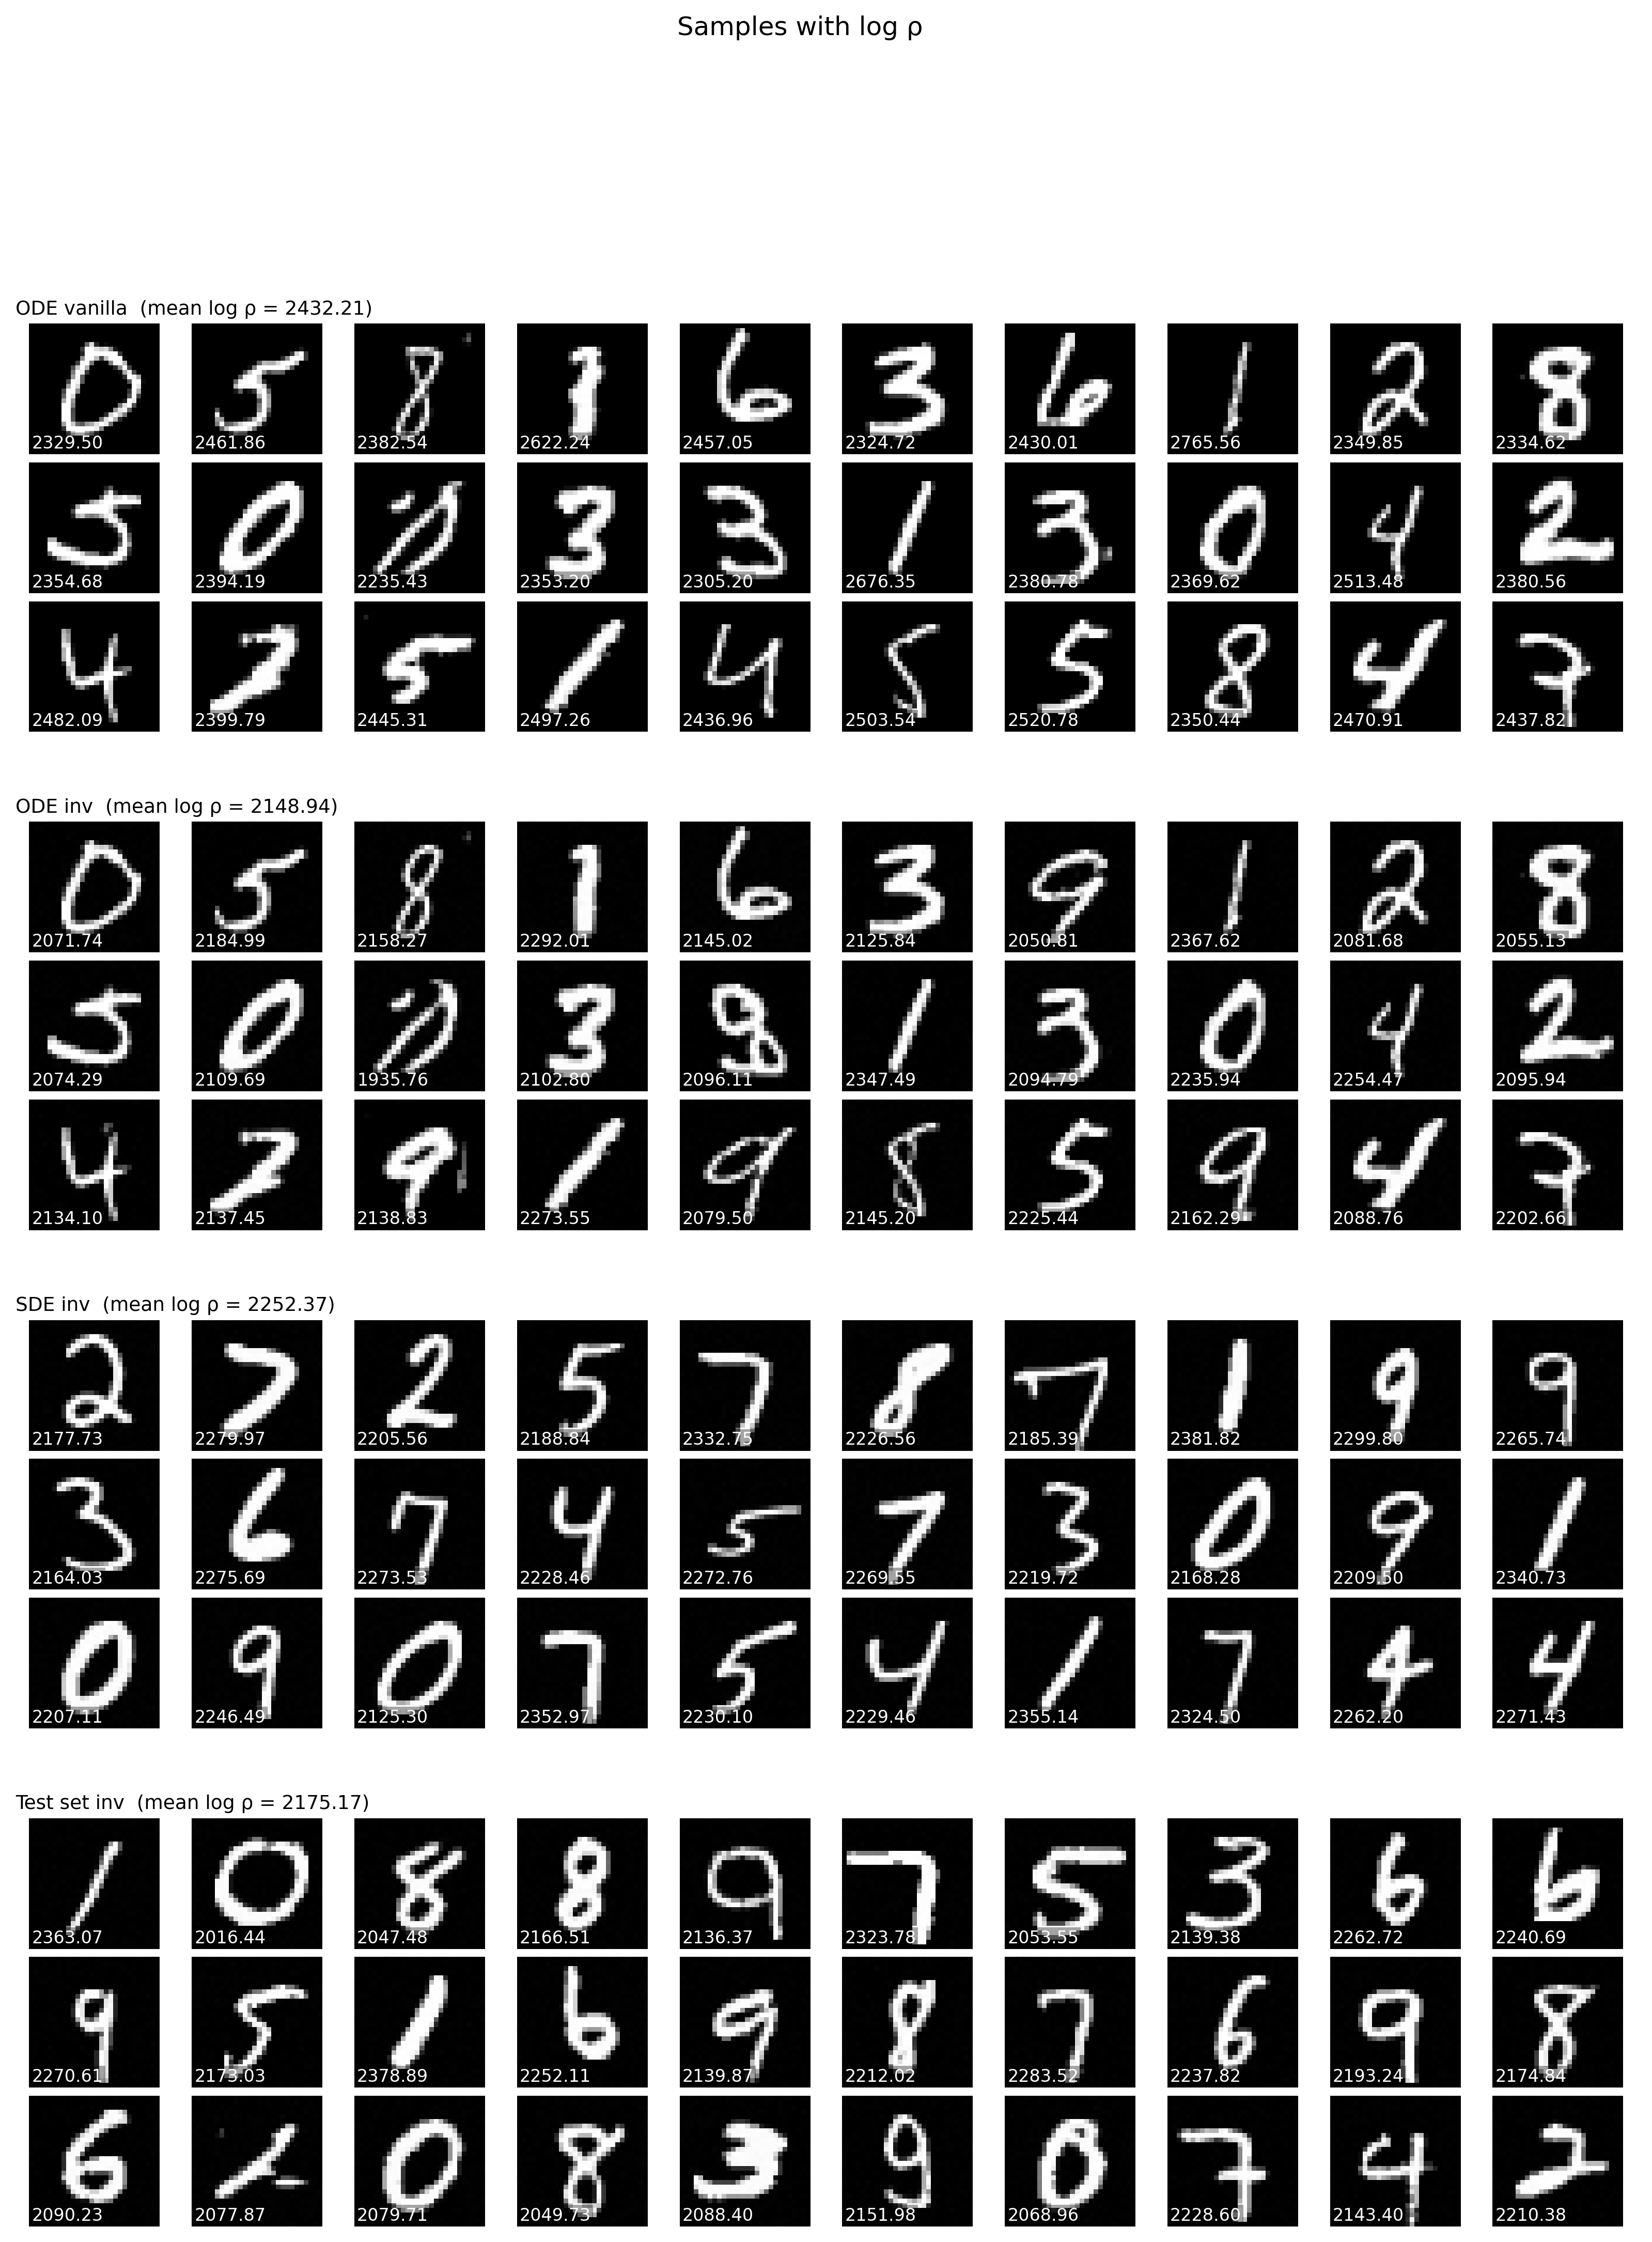

In [14]:
@torch.no_grad()
def plot_images_with_logrho(
    images: torch.Tensor,
    log_rho: torch.Tensor,
    nrow: int = 10,
    title: str | None = None,
    digits: int = 2,
    dpi: int = 300,
    fontsize: int = 8,
    normalize_from_neg1_pos1: bool = True,
    save_path: str | None = None,
    group_titles: list[str] | None = None,
    group_size: int | None = None,
    show_group_mean: bool = False,
):
    import math
    import matplotlib.pyplot as plt
    from matplotlib import gridspec

    assert images.ndim == 4, "images should be (B, C, H, W)"
    B = images.shape[0]
    cols = min(nrow, B)

    imgs = images.detach().cpu().clone()
    if normalize_from_neg1_pos1:
        imgs = (imgs * 0.5 + 0.5).clamp(0, 1)

    scores = log_rho.detach().cpu().view(-1)
    assert scores.numel() == B, "log_rho length must match number of images"

    groups = []
    if group_titles is not None and group_size is not None:
        total_needed = group_size * len(group_titles)
        assert total_needed <= B, "group_size * len(group_titles) exceeds number of images"
        start = 0
        for name in group_titles:
            end = start + group_size
            groups.append((name, start, end))
            start = end
    else:
        groups.append(("All", 0, B))

    rows_per_group = [math.ceil((e - s) / cols) for _, s, e in groups]

    col_width  = 1.35
    row_height = 1.30
    title_frac = 0.10     
    group_hspace = 0.16   
    cell_hspace  = 0.08   
    cell_wspace  = 0.03   

    fig_w = cols * col_width
    fig_h = sum(r * row_height + title_frac * row_height for r in rows_per_group)

    fig = plt.figure(figsize=(fig_w, fig_h), dpi=dpi)
    outer = gridspec.GridSpec(
        nrows=len(groups), ncols=1,
        height_ratios=[(title_frac + r) for r in rows_per_group],
        hspace=group_hspace,
    )

    for gi, (gname, s, e) in enumerate(groups):
        r = rows_per_group[gi]
        sub = outer[gi].subgridspec(
            r + 1, cols,
            height_ratios=[title_frac] + [1]*r,
            wspace=cell_wspace, hspace=cell_hspace
        )

        ax_title = fig.add_subplot(sub[0, :])
        ax_title.axis("off")
        if show_group_mean:
            mean_val = scores[s:e].mean().item()
            txt = f"{gname}  (mean log ρ = {mean_val:.{digits}f})"
        else:
            txt = gname
        ax_title.text(0.0, 0.5, txt, fontsize=fontsize+1, va="center", ha="left")

        for k in range(r * cols):
            ax = fig.add_subplot(sub[1 + k // cols, k % cols])
            idx = s + k
            if idx < e:
                img = imgs[idx]
                if img.shape[0] == 1:
                    ax.imshow(img.squeeze(0), cmap="gray")
                else:
                    ax.imshow(img.permute(1, 2, 0).numpy())
                ax.set_xticks([]); ax.set_yticks([])
                for sp in ax.spines.values():
                    sp.set_visible(False)

                label = f"{scores[idx].item():.{digits}f}"
                ax.text(
                    0.02, 0.02, label,
                    transform=ax.transAxes, ha="left", va="bottom",
                    fontsize=fontsize, color="white",
                    bbox=dict(facecolor="black", alpha=0.35, pad=1.0, edgecolor="none"),
                )
            else:
                ax.axis("off")

    if title is not None:
        fig.suptitle(title, fontsize=12, y=0.995)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight", pad_inches=0.05)
    plt.show()


plot_images_with_logrho(
    images=details["states_used"][-1],
    log_rho=log_rho_eval[:],
    nrow=10,
    title="Samples with log ρ",
    digits=2,
    dpi=300,
    fontsize=8,
    group_titles=["ODE vanilla", "ODE inv", "SDE inv", "Test set inv"],
    group_size=n_samples,
    show_group_mean=True,
)

## Log Likelihood Estimation from KL Divergence 

For a given data point  $x^{\mathrm{eval}} $, we can derive the following formula for log likelihood:

$$
\begin{aligned}

\log \rho_t(x^{\mathrm{eval}}) 
&= \int_0^1 \frac{t}{1 - t} 
\, \mathbb{E}\!\left[ 
\| \dot{X}_t^{\mathrm{eval}} \|^2 
- 
\| \dot{X}_t^{\mathrm{eval}} - v_t(X_t^{\mathrm{eval}}) \|^2 
\right] \mathrm dt  \\

&= \int_0^1 \frac{t}{1 - t} 
\, \mathbb{E}\!\left[ 
2 \,v_t(X_t^{\mathrm{eval}})\dot{X}_t^{\mathrm{eval}}
- 
\|v_t(X_t^{\mathrm{eval}}) \|^2 
\right] \mathrm dt 

\end{aligned}
$$

where 
$$
X_t^{\mathrm{eval}} = t x^{\mathrm{eval}} + (1 - t) X_0,
\quad \text{with } X_0 \sim \mathrm{Normal}(0, I).
$$


In [15]:
x_1 = details["states_used"][-1]

print(x_1.shape)

torch.Size([120, 1, 28, 28])


In [22]:
@torch.no_grad()
def estimate_loglik_from_KL_chunked(
    v_func,
    x_eval: torch.Tensor,
    n_t: int = 64,
    n_x0: int = 256,
    t_eps: float = 1e-3,
    x0_chunk: int = 64,
    acc_dtype: torch.dtype = torch.float32,
):
    assert 0.0 < t_eps < 0.5
    device, fwd_dtype = x_eval.device, x_eval.dtype
    B = x_eval.shape[0]
    rest_shape = x_eval.shape[1:]
    D = int(torch.tensor(rest_shape).prod().item()) if len(rest_shape) else 1

    X0_full = torch.randn((B, n_x0, *rest_shape), device=device, dtype=fwd_dtype)

    grid = torch.arange(n_t, device=device, dtype=acc_dtype)
    t_grid = (grid + 0.5) / n_t                      
    t_grid = t_eps + (1.0 - 2.0 * t_eps) * t_grid
    delta_t = (1.0 - 2.0 * t_eps) / n_t
    print("t_grid:", t_grid)
    print("delta_t:", delta_t)
    t_weights = (t_grid / (1.0 - t_grid)) * delta_t  # (n_t,)

    out = torch.zeros((B,), device=device, dtype=acc_dtype)
    x_eval_u1_fwd = x_eval.unsqueeze(1)  # (B,1,...)

    for t_acc, w in tqdm(zip(t_grid, t_weights), total=n_t):
        t = t_acc.to(fwd_dtype)
        w = w.to(acc_dtype)
        print("Processing t =", t.item(), "with weight =", w.item())

        accum_b = torch.zeros((B,), device=device, dtype=acc_dtype)

        for i in range(0, n_x0, x0_chunk):
            csz = min(x0_chunk, n_x0 - i)

            X0_chunk = X0_full[:, i:i+csz]  # fwd_dtype
            x_t_chunk = t * x_eval_u1_fwd + (1.0 - t) * X0_chunk

            dot_xt = (
                x_eval_u1_fwd.to(acc_dtype).expand(-1, csz, *rest_shape)
                - X0_chunk.to(acc_dtype)
            ).reshape(B * csz, -1)  # (B*csz, D)

            x_t_flat = x_t_chunk.reshape(B * csz, *rest_shape)  # fwd_dtype
            t_vec = torch.full((B * csz,), float(t.item()), device=device, dtype=fwd_dtype)
            v = v_func(x_t_flat, t_vec)

            v_flat = v.reshape(B * csz, -1).to(acc_dtype)

            contrib = 2.0 * (dot_xt * v_flat).sum(dim=1) - (v_flat * v_flat).sum(dim=1)
            contrib = contrib.view(B, csz).sum(dim=1)

            accum_b += contrib

        out += w * (accum_b / float(n_x0))

    return out

result = estimate_loglik_from_KL_chunked(
    v_func=flow_model,
    x_eval=x_1,
    n_t=50,
    n_x0=128,
    t_eps=1e-3,
)

t_grid: tensor([0.0110, 0.0309, 0.0509, 0.0709, 0.0908, 0.1108, 0.1307, 0.1507, 0.1707,
        0.1906, 0.2106, 0.2305, 0.2505, 0.2705, 0.2904, 0.3104, 0.3303, 0.3503,
        0.3703, 0.3902, 0.4102, 0.4301, 0.4501, 0.4701, 0.4900, 0.5100, 0.5299,
        0.5499, 0.5699, 0.5898, 0.6098, 0.6297, 0.6497, 0.6697, 0.6896, 0.7096,
        0.7295, 0.7495, 0.7695, 0.7894, 0.8094, 0.8293, 0.8493, 0.8693, 0.8892,
        0.9092, 0.9291, 0.9491, 0.9691, 0.9890], device='cuda:0')
delta_t: 0.01996


  0%|          | 0/50 [00:00<?, ?it/s]

Processing t = 0.010979999788105488 with weight = 0.0002215938875451684


  2%|▏         | 1/50 [00:00<00:28,  1.72it/s]

Processing t = 0.030939999967813492 with weight = 0.000637279765214771


  4%|▍         | 2/50 [00:01<00:43,  1.10it/s]

Processing t = 0.05089999735355377 with weight = 0.0010704498272389174


  6%|▌         | 3/50 [00:02<00:47,  1.01s/it]

Processing t = 0.07086000591516495 with weight = 0.001522231032140553


  8%|▊         | 4/50 [00:03<00:48,  1.06s/it]

Processing t = 0.09081999957561493 with weight = 0.0019938484765589237


 10%|█         | 5/50 [00:05<00:49,  1.09s/it]

Processing t = 0.11078000068664551 with weight = 0.002486638491973281


 12%|█▏        | 6/50 [00:06<00:48,  1.11s/it]

Processing t = 0.1307400017976761 with weight = 0.0030020596459507942


 14%|█▍        | 7/50 [00:07<00:48,  1.12s/it]

Processing t = 0.15070000290870667 with weight = 0.0035417070612311363


 16%|█▌        | 8/50 [00:08<00:47,  1.13s/it]

Processing t = 0.17066000401973724 with weight = 0.004107330460101366


 18%|█▊        | 9/50 [00:09<00:46,  1.13s/it]

Processing t = 0.19062000513076782 with weight = 0.004700851626694202


 20%|██        | 10/50 [00:10<00:45,  1.13s/it]

Processing t = 0.2105800062417984 with weight = 0.0053243860602378845


 22%|██▏       | 11/50 [00:11<00:44,  1.13s/it]

Processing t = 0.23053999245166779 with weight = 0.005980269517749548


 24%|██▍       | 12/50 [00:13<00:43,  1.14s/it]

Processing t = 0.25049999356269836 with weight = 0.006671086885035038


 26%|██▌       | 13/50 [00:14<00:42,  1.14s/it]

Processing t = 0.27045997977256775 with weight = 0.007399705238640308


 28%|██▊       | 14/50 [00:15<00:40,  1.14s/it]

Processing t = 0.2904199957847595 with weight = 0.008169315755367279


 30%|███       | 15/50 [00:16<00:39,  1.14s/it]

Processing t = 0.3103800117969513 with weight = 0.008983476087450981


 32%|███▏      | 16/50 [00:17<00:38,  1.14s/it]

Processing t = 0.3303399682044983 with weight = 0.00984616857022047


 34%|███▍      | 17/50 [00:18<00:37,  1.14s/it]

Processing t = 0.35029998421669006 with weight = 0.010761870071291924


 36%|███▌      | 18/50 [00:19<00:36,  1.14s/it]

Processing t = 0.37026000022888184 with weight = 0.01173562090843916


 38%|███▊      | 19/50 [00:21<00:35,  1.14s/it]

Processing t = 0.3902199864387512 with weight = 0.012773115187883377


 40%|████      | 20/50 [00:22<00:34,  1.14s/it]

Processing t = 0.410180002450943 with weight = 0.013880832120776176


 42%|████▏     | 21/50 [00:23<00:33,  1.14s/it]

Processing t = 0.4301399886608124 with weight = 0.015066145919263363


 44%|████▍     | 22/50 [00:24<00:31,  1.14s/it]

Processing t = 0.45009997487068176 with weight = 0.016337504610419273


 46%|████▌     | 23/50 [00:25<00:30,  1.14s/it]

Processing t = 0.47005999088287354 with weight = 0.017704639583826065


 48%|████▊     | 24/50 [00:26<00:29,  1.14s/it]

Processing t = 0.4900199770927429 with weight = 0.019178787246346474


 50%|█████     | 25/50 [00:27<00:28,  1.14s/it]

Processing t = 0.5099799633026123 with weight = 0.0207730270922184


 52%|█████▏    | 26/50 [00:29<00:27,  1.14s/it]

Processing t = 0.5299399495124817 with weight = 0.022502658888697624


 54%|█████▍    | 27/50 [00:30<00:26,  1.14s/it]

Processing t = 0.5498999953269958 with weight = 0.02438569813966751


 56%|█████▌    | 28/50 [00:31<00:25,  1.14s/it]

Processing t = 0.5698599815368652 with weight = 0.026443492621183395


 58%|█████▊    | 29/50 [00:32<00:23,  1.14s/it]

Processing t = 0.5898199677467346 with weight = 0.028701556846499443


 60%|██████    | 30/50 [00:33<00:22,  1.14s/it]

Processing t = 0.6097800135612488 with weight = 0.03119063191115856


 62%|██████▏   | 31/50 [00:34<00:21,  1.14s/it]

Processing t = 0.6297399997711182 with weight = 0.03394806385040283


 64%|██████▍   | 32/50 [00:35<00:20,  1.14s/it]

Processing t = 0.6496999859809875 with weight = 0.03701972961425781


 66%|██████▌   | 33/50 [00:37<00:19,  1.14s/it]

Processing t = 0.6696599721908569 with weight = 0.04046258702874184


 68%|██████▊   | 34/50 [00:38<00:18,  1.14s/it]

Processing t = 0.6896200180053711 with weight = 0.04434826970100403


 70%|███████   | 35/50 [00:39<00:17,  1.14s/it]

Processing t = 0.7095800042152405 with weight = 0.048768047243356705


 72%|███████▏  | 36/50 [00:40<00:15,  1.14s/it]

Processing t = 0.7295399904251099 with weight = 0.053840190172195435


 74%|███████▍  | 37/50 [00:41<00:14,  1.14s/it]

Processing t = 0.7494999766349792 with weight = 0.05972062796354294


 76%|███████▌  | 38/50 [00:42<00:13,  1.14s/it]

Processing t = 0.7694599628448486 with weight = 0.06661932170391083


 78%|███████▊  | 39/50 [00:43<00:12,  1.14s/it]

Processing t = 0.789419949054718 with weight = 0.07482580095529556


 80%|████████  | 40/50 [00:45<00:11,  1.14s/it]

Processing t = 0.8093799948692322 with weight = 0.0847509354352951


 82%|████████▏ | 41/50 [00:46<00:10,  1.14s/it]

Processing t = 0.8293399810791016 with weight = 0.09699767827987671


 84%|████████▍ | 42/50 [00:47<00:09,  1.14s/it]

Processing t = 0.849299967288971 with weight = 0.11248854547739029


 86%|████████▌ | 43/50 [00:48<00:07,  1.14s/it]

Processing t = 0.8692600131034851 with weight = 0.13270942866802216


 88%|████████▊ | 44/50 [00:49<00:06,  1.14s/it]

Processing t = 0.8892199993133545 with weight = 0.16021692752838135


 90%|█████████ | 45/50 [00:50<00:05,  1.14s/it]

Processing t = 0.9091799855232239 with weight = 0.19981533288955688


 92%|█████████▏| 46/50 [00:51<00:04,  1.14s/it]

Processing t = 0.929140031337738 with weight = 0.26172229647636414


 94%|█████████▍| 47/50 [00:52<00:03,  1.14s/it]

Processing t = 0.9491000175476074 with weight = 0.37218156456947327


 96%|█████████▌| 48/50 [00:54<00:02,  1.14s/it]

Processing t = 0.9690600037574768 with weight = 0.6251596808433533


 98%|█████████▊| 49/50 [00:55<00:01,  1.14s/it]

Processing t = 0.9890199899673462 with weight = 1.797888994216919


100%|██████████| 50/50 [00:56<00:00,  1.13s/it]


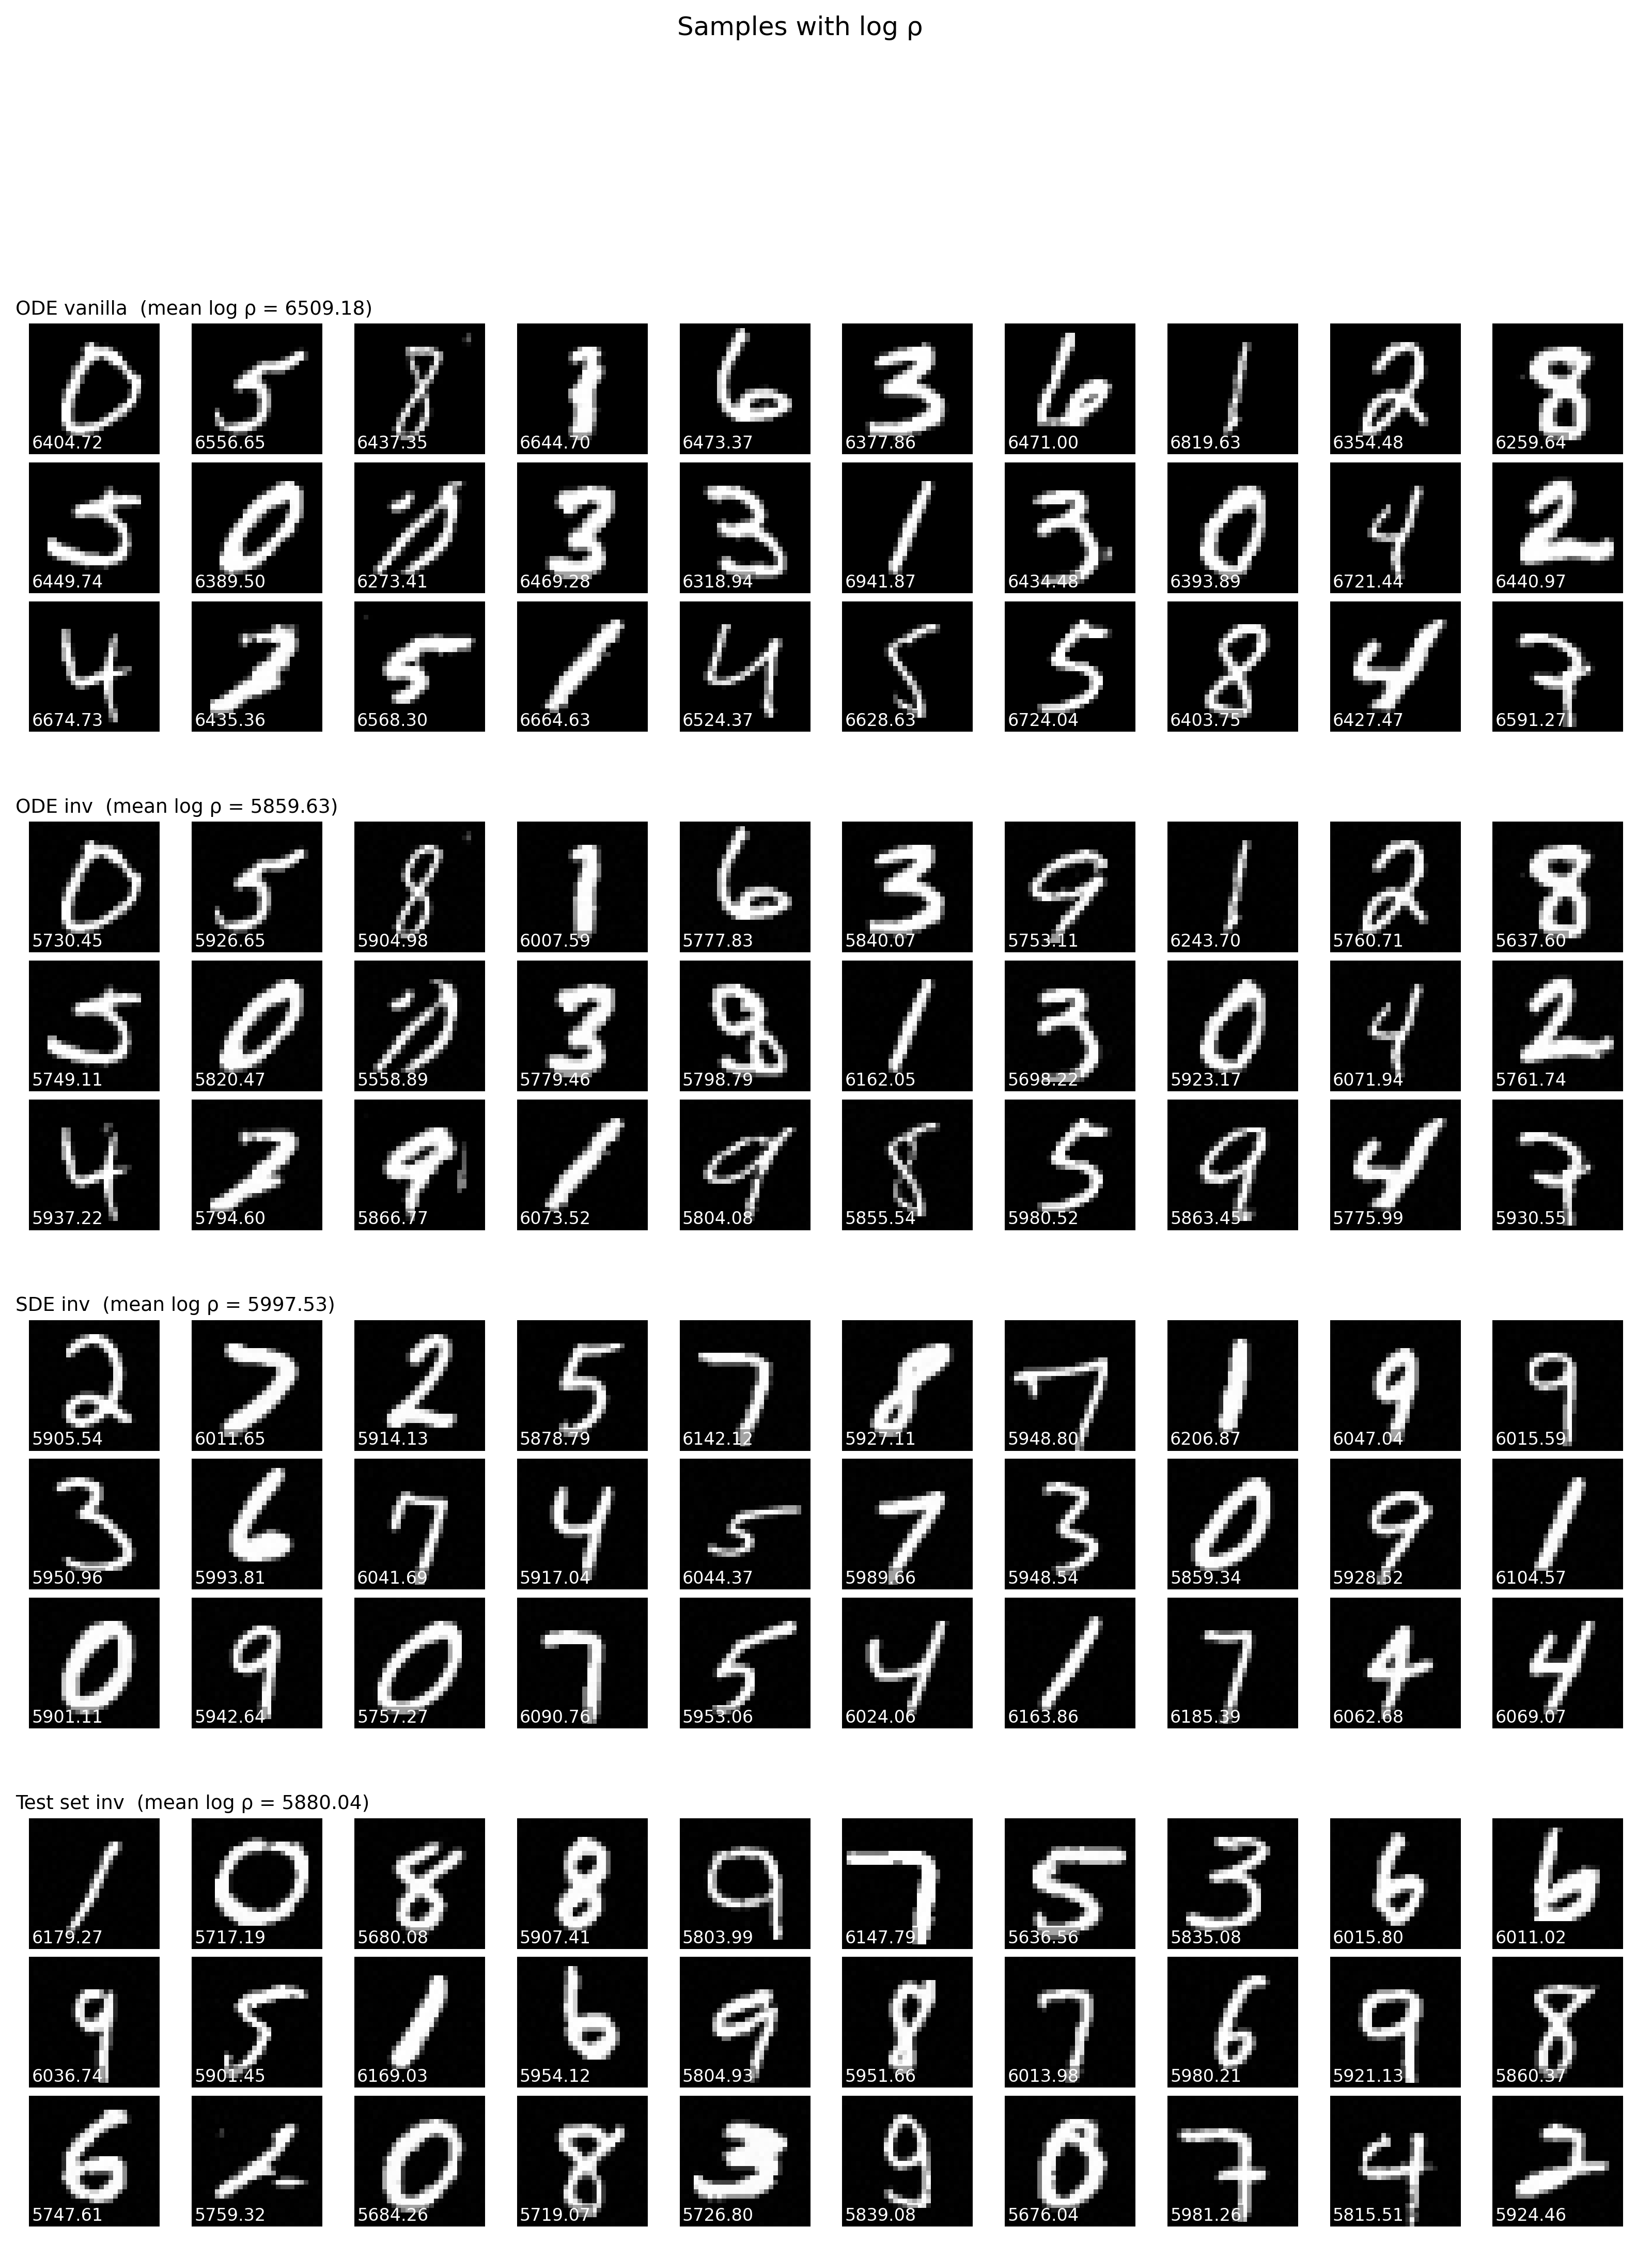

In [17]:
plot_images_with_logrho(
    images=details["states_used"][-1],
    log_rho=result,
    nrow=10,
    title="Samples with log ρ",
    digits=2,
    dpi=300,
    fontsize=8,
    group_titles=["ODE vanilla", "ODE inv", "SDE inv", "Test set inv"],
    group_size=n_samples,
    show_group_mean=True,
)